# `IMPORTS`

In [1]:
import math
import inflection
import random
import pickle

import pandas               as pd
import numpy                as np
import datetime             as dt
import missingno            as msno
import seaborn              as sns
import xgboost              as xgb
import matplotlib.pyplot    as plt
import ptitprince           as pt
import plotly.graph_objs    as go

from scipy                  import stats as ss

from boruta                 import BorutaPy
from IPython.display        import Image
from matplotlib.gridspec    import GridSpec
from IPython.core.display   import HTML
from tabulate               import tabulate
from yellowbrick.target     import FeatureCorrelation
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [100]:
def jupyter_settings():
    #%matplotlib inline 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()


# Método V de Cramer
def cramer_v(x, y):
    # Matriz de Confusão
    confusion_matrix = pd.crosstab(x, y).values
    #  A soma de todos os valores
    n = confusion_matrix.sum()
    # Número de linhas e colunas
    r, k = confusion_matrix.shape

    # Qui-quadrado
    chi2 = ss.chi2_contingency( confusion_matrix )[0]
    
    # Correção de viés
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    # V de Cramer
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)) )

# Função de Avaliação de Modelos com Métricas de Erro
def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({   'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse,
                        }, index=[0])

# Cross_validation
# Apenas aplicável a tarefas envolvendo séries temporais, utilizando validação cruzada K-Fold.
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    """ Calcula e retorna a performance real de um modelo com base nas métricas de erro 'MAE', 'MAPE' e 'RMSE',
        no formato (erro ± 1 desvio padrão).
        Parâmetros:
            x_training: conjunto de dados de treino
            kfold: número de divisões (folds)
            model_name: nome do modelo
            model: instância do modelo a ser treinado
            verbose: define se os logs detalhados serão exibidos (True para exibir)
    """
    
    mae_list = []
    mape_list = []
    rmse_list = []

    k = 1
    # Itera sobre os folds em ordem decrescente
    for k in reversed(range(1, kfold + 1)):
        # Calcula as datas de início e fim do treino e validação para cada iteração. Use verbose para detalhes.
        validation_start_date = x_training['date'].max() - dt.timedelta(days=k * 6 * 7) 
        validation_end_date = x_training['date'].max() - dt.timedelta(days=(k - 1) * 6 * 7)

        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        if verbose: 
            print('\nNúmero do KFold: ', k)
            print('Data de início do treino KFold: ', training['date'].min())
            print('Data de fim do treino KFold: ', training['date'].max())
            print('Data de início da validação KFold: ', validation_start_date)
            print('Data de fim da validação KFold: ', validation_end_date)
            
        # Conjuntos de treino e validação:
        # Exclui as colunas 'date' e 'sales' para o treinamento e validação:
        xtraining = training.drop(['date', 'sales'], axis=1)  # variáveis explicativas
        ytraining = training['sales']  # variável resposta            
        xvalidation = validation.drop(['date', 'sales'], axis=1)  # variáveis explicativas
        yvalidation = validation['sales']  # variável resposta

        # Treinamento do modelo (sobre os dados de treino)
        m = model.fit(xtraining, ytraining)

        # Predição do modelo (sobre os dados de validação)
        yhat = m.predict(xvalidation)

        # Avaliação de performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Armazena a performance de cada iteração do KFold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    # Cria um dicionário calculando a média e o desvio padrão de cada erro,
    # retornando um DataFrame com a performance do modelo no formato: (erro ± 1 std):
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' ± ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' ± ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' ± ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

# MPE - Mean Percentage Error
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y) 

## Loading Data

In [3]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# `DESCRIÇÃO DOS DADOS`

In [4]:
df1 = df_raw.copy()

## Data Fields

| **Coluna** | **Descrição** |
|---|---|
| **Id** | Um ID que representa uma duplicata (Loja, Data) dentro do conjunto de teste |
| **Loja (Store)** | Um ID exclusivo para cada loja |
| **Vendas (Sales)** | O volume de negócios para um determinado dia (é o que você está prevendo) |
| **Clientes (Customers)** | O número de clientes em um determinado dia |
| **Aberto (Open)** | Um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto |
| **Feriado Estadual (StateHoliday)** | Indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Observe que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado da páscoa, c = natal, 0 = nenhum |
| **Feriado Escolar (SchoolHoliday)** | Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas |
| **Sortimento (Assortment)** | Descreve um nível de sortimento: a = básico, b = extra, c = estendido |
| **Distância da Concorrência (CompetitionDistance)** | Distância em metros até a loja concorrente mais próxima |
| **Abertura da Concorrência (CompetitionOpenSince[Month/Year])** | Fornece o ano e o mês aproximados em que o concorrente mais próximo foi aberto |
| **Promoção (Promo)** | Indica se uma loja está executando uma promoção naquele dia |
| **Promoção 2 (Promo2)** | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando |
| **Início da Promoção 2 (Promo2Since[Year/Week])** | Descreve o ano e a semana do calendário em que a loja começou a participar do Promo2 |
| **Intervalo da Promoção (PromoInterval)** | Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja |


## Rename Columns

In [5]:
# Lista das colunas originais
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Função para transformar os nomes das colunas em snake_case
snakecase = lambda x: inflection.underscore(x)

# Aplica a função em todas as palavras de cols_old, armazenando os resultados em cols_new
cols_new = [snakecase(col) for col in cols_old]

# Renomeia as colunas do DataFrame df1 com os novos nomes em snake_case
df1.columns = cols_new

## Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## Data Types

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
# Converter a coluna 'date' para datetime
df1['date'] = pd.to_datetime(df1['date'])

## Check NA

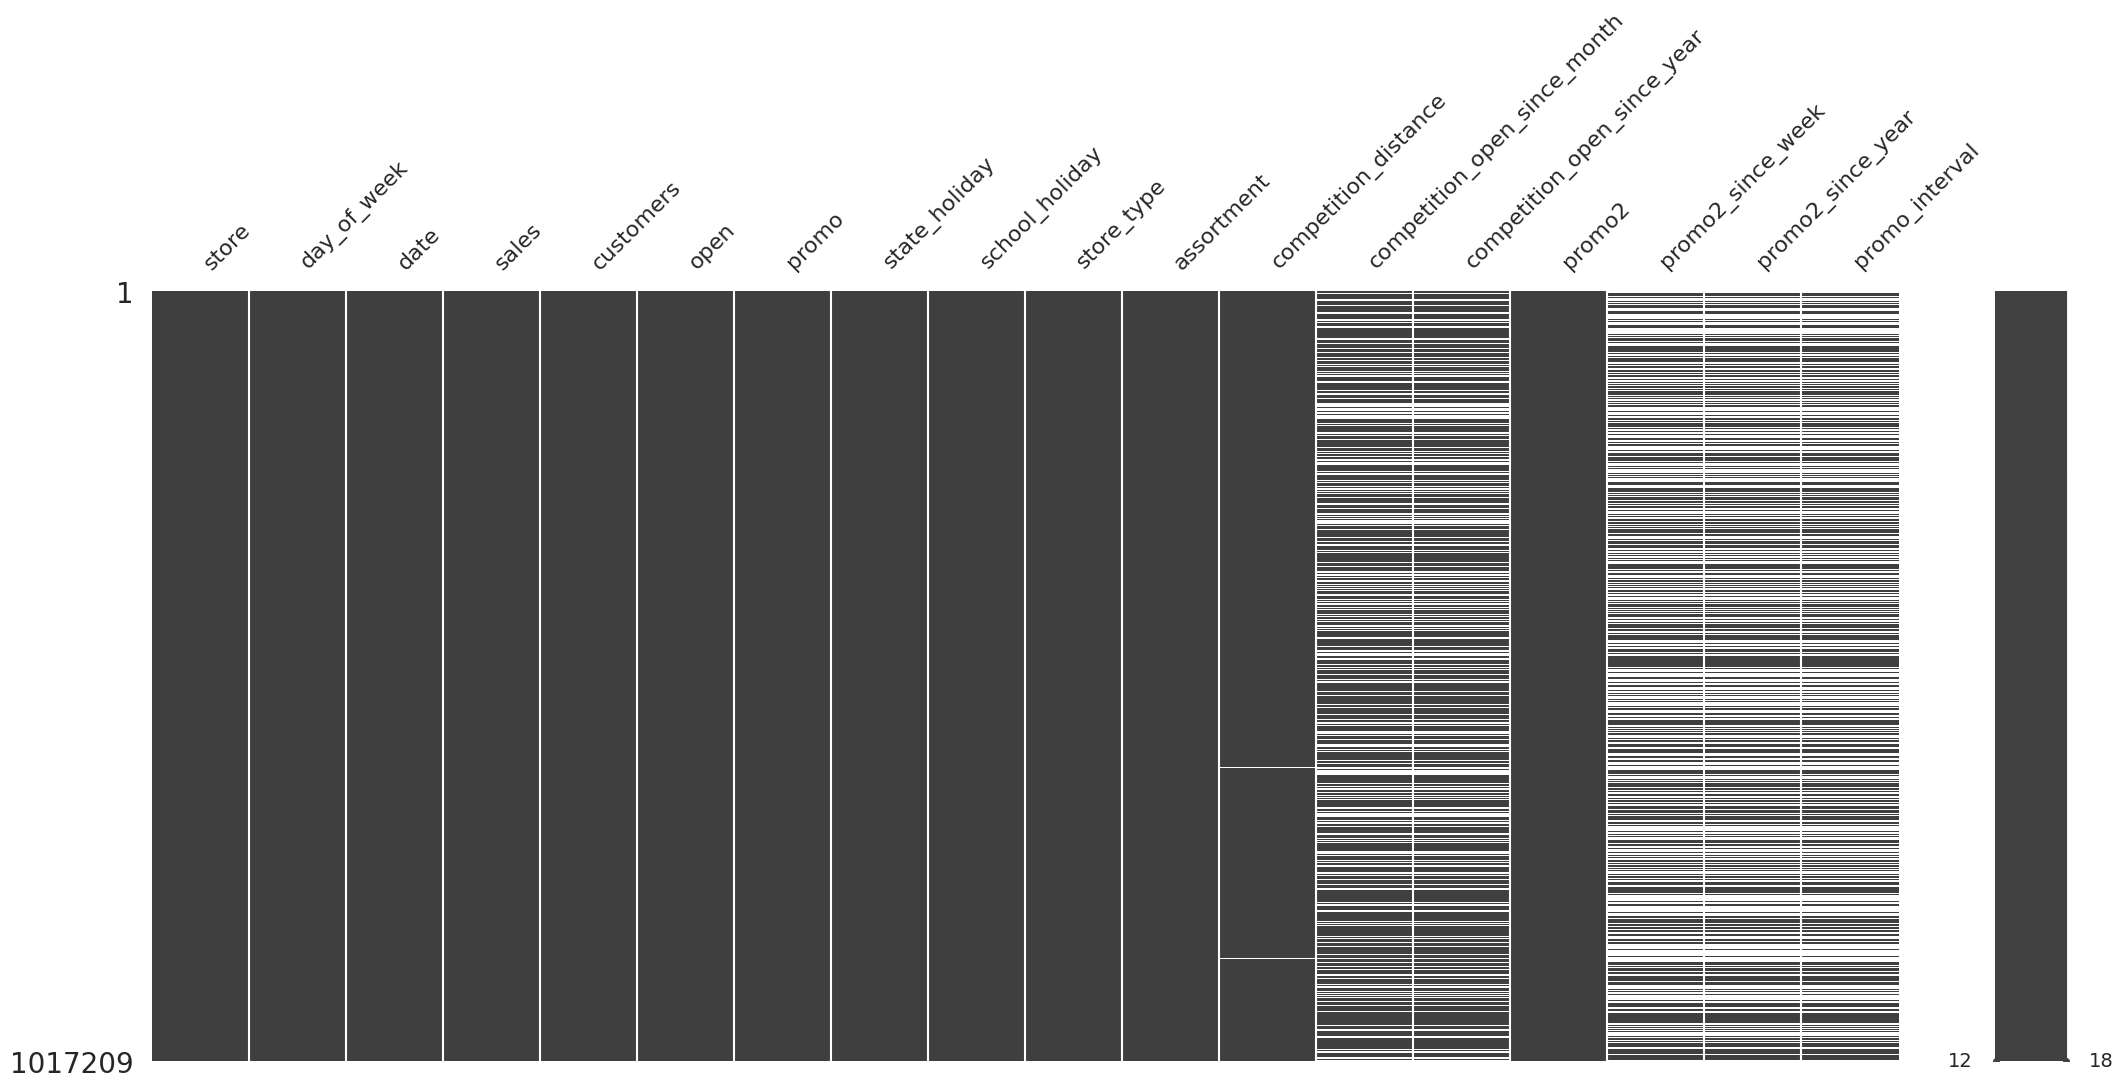

In [9]:
# Mostrar uma matriz de valores ausentes (NaN) no DataFrame df1 usando a função msno.matrix
msno.matrix(df1);

In [10]:
# Contar o número de valores ausentes (NaN) em cada coluna do DataFrame df1
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Analyze all NA cases

**Casos de NA para serem tratados:**

| **Colunas**                      | **NA**    |
|----------------------------------|-----------|
| competition_distance             | 2642      |
| competition_open_since_month     | 323348    |
| competition_open_since_year      | 323348    |
| promo2_since_week                | 508031    |
| promo2_since_year                | 508031    |
| promo_interval                   | 508031    |


#### Caso 1 - Competition_distance: indica a distancia em metros do competidor mais próximo

In [11]:
""" 
Assumindo que no caso de valores ausente não há competidores próximos.
Vou vou atribuir pros NAs um valor bem maior que o maior valor de distância existente.
"""

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#### Caso 2 - competition_open_since_month: indica o mês aproximado da abertura do competidor mais próximo

In [12]:
"""
Se esta coluna está vazia, é porque pode não haver competidor próximo ou pode ser devido à falta de informação sobre a data de abertura.
Vou assumir que a data de venda (date) é a mesma que a data de abertura do competidor.
"""

df1['competition_open_since_month'] = df1.apply(lambda x: x.date.month if math.isnan(x.competition_open_since_month) else x.competition_open_since_month, axis=1)


#### Caso 3 - competition_open_since_year: indica ano aproximado da abertura do competidor mais próximo

In [13]:
# Vou assumir para years a mesama solução realizada em month
df1['competition_open_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year, axis=1)

#### Caso 4 - promo2_since_week: indica a semana do calendário em que a loja começou a participar do Promo2

In [14]:
"""
Descreve a semana do calendário em que a loja começou a participar do Promo2
Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

vou manter a mesma estratégia, utilizando a data de venda como referência para definir esses valores.
"""

df1['promo2_since_week'] = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis=1)

#### Caso 5 - promo2_since_year: indica o ano do calendário em que a loja começou a participar do Promo2

In [15]:
"""
Descreve o ano do calendário em que a loja começou a participar do Promo2
Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

vou manter a mesma estratégia, utilizando a data de venda como referência para definir esses valores.
"""

df1['promo2_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis=1)

#### Caso 6 - promo_interval: indica o intervalo de tempo entre as promoções

In [16]:
"""
Para resolver a questão dos valores NA neste caso, 
optei em preenchê-los com zeros como uma medida para garantir a integridade dos dados 
e simplificar as etapas de análise subsequentes.
"""

# month_map é um dicionário que mapeia números de mês para abreviações de meses.
month_map = {1: 'jan', 
             2: 'Feb', 
             3: 'Mar', 
             4: 'Apr', 
             5: 'May',
             6: 'Jun', 
             7: 'Jul', 
             8: 'Aug', 
             9: 'Sept', 
             10:'Oct', 
             11:'Nov', 
             12:'Dec'}

# Preenche os valores ausentes na coluna 'promo_interval' com 0 e modifica o DataFrame inplace.
df1['promo_interval'].fillna(0, inplace=True);

# Cria uma nova coluna 'month_map' que mapeia os meses baseado na coluna 'date'.
df1['month_map'] = df1['date'].dt.month.map(month_map);

# Cria uma nova coluna 'is_promo' para indicar se uma promoção está ocorrendo no mês correspondente.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1);


### Result

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change Types

In [18]:
# Após as alterações realizadas nas colunas, é essencial verificar se o formato dos dados permaneceu o mesmo.
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
# converter de float pra int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [20]:
# Conferindo
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Descriptive Statistical

In [21]:
#Separação de Variáveis Numéricas e Categóricas para Aplicação da analise descritiva:
num_attributes = df1.select_dtypes ( include=['int64','float64'] )
cat_attributes = df1.select_dtypes ( exclude=['int64','float64','datetime64[ns]'] )

### Numerical Attribures

In [22]:
#Central Tendency - mean - median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - STD, min, max, range, sken, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


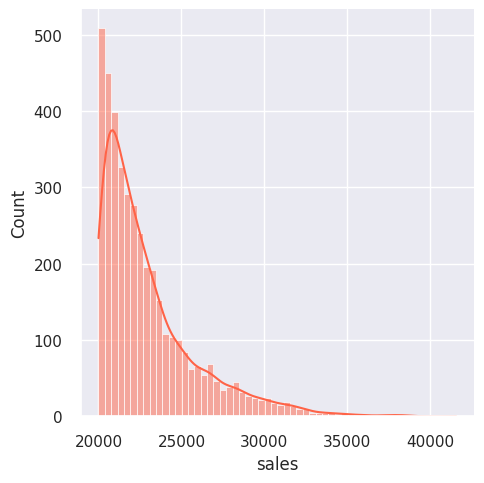

In [23]:
# Criar uma máscara booleana para identificar valores de 'sales' maiores que 20000
aux = df1['sales'] > 20000

# Aplicar a máscara para selecionar os dados filtrados da coluna 'sales'
dados_filt = df1.loc[aux, 'sales']

# Plotar o histograma com KDE para os dados filtrados
sns.displot(dados_filt, kde=True, color='#FF6347');

### Categorical Attibures

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

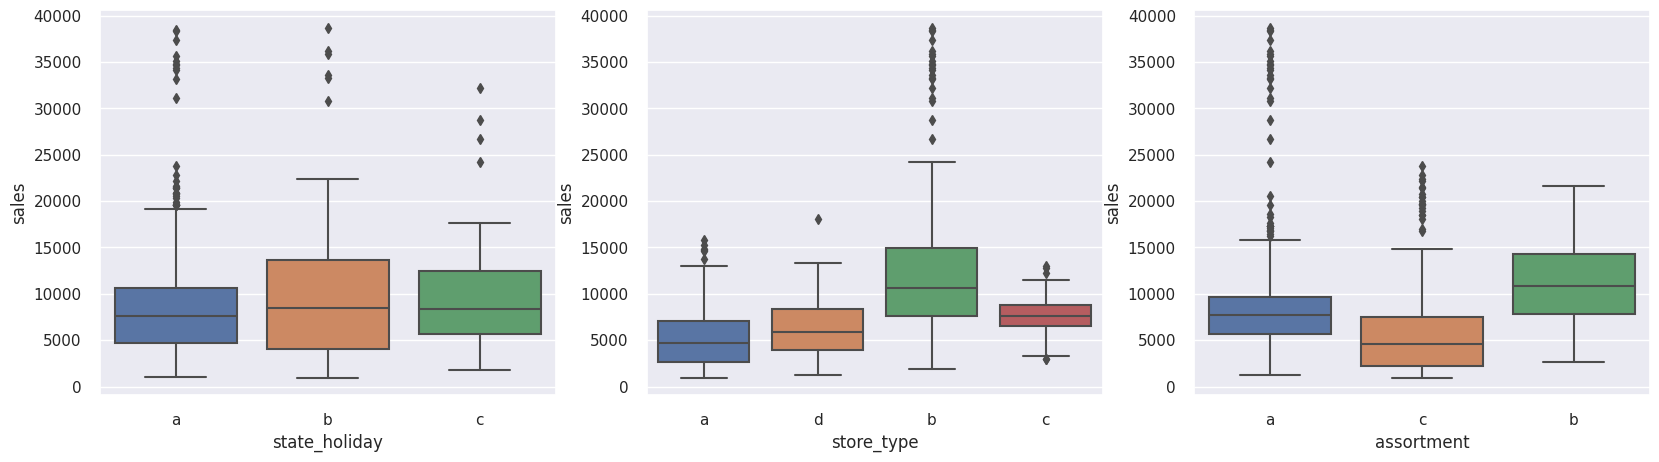

In [25]:
# Paleta de cores personalizada
# cores = ["#FF6347", "#4682B4", "#32CD32", "#FFD700"]

#Atualizei o cálculo para desconsiderar os dias sem vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] 

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

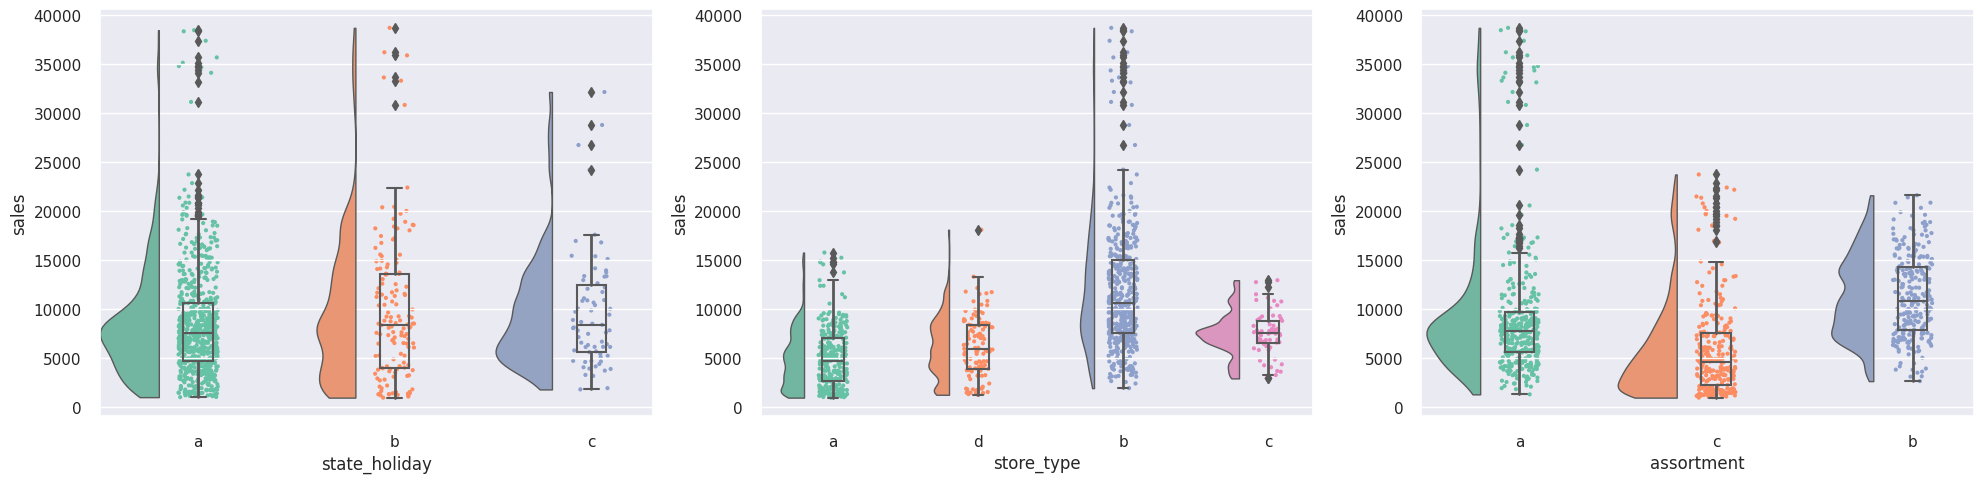

In [26]:
# Configurações para o gráfico de nuvem de chuva (RainCloud plot)
pal = 'Set2'  # Paleta de cores
sigma = .2  # Largura do KDE
ort = 'v'  # Orientação do gráfico (vertical)

# a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# gráfico de nuvem de chuva (RainCloud plot) para cada subplot
pt.RainCloud(x='state_holiday', y='sales', palette=pal, bw=sigma, width_viol=.6, ax=axes[0], orient=ort, data=aux1)
pt.RainCloud(x='store_type', y='sales', palette=pal, bw=sigma, width_viol=.6, ax=axes[1], orient=ort, data=aux1)
pt.RainCloud(x='assortment', y='sales', palette=pal, bw=sigma, width_viol=.6, ax=axes[2], orient=ort, data=aux1)

plt.tight_layout()  # Ajusta automaticamente o layout para evitar sobreposição

#### `Análise do violinplot 1: quantidade de vendas por tipo de feriado:`

Legenda de :
- a = feriado público
- b = feriado de Páscoa
- c = Natal

A mediana de vendas nos feriados de Páscoa (b) e Natal (c) é mais alta do que nos feriados públicos (a).

A mediana de vendas nos feriados de Páscoa (b) e Natal (c) é semelhante, porém a dispersão é maior durante a Páscoa.

#### `Análise do violinplot 2: quantidade de vendas por tipo de loja:`

Legenda de StoreType:
- a
- d
- b
- c

A loja do tipo b vende aproximadamente o dobro da mediana em comparação com as outras, especialmente a do tipo a.

A concentração de vendas ao redor da mediana é maior para a loja do tipo c.

#### `Análise do violinplot 3: quantidade de vendas por mix de produtos:`

Legenda de Assortment:
- a = básico
- b = extra
- c = estendido

O mix de produtos extra (b) tem significativamente mais vendas do que os outros. Além disso, a variabilidade nas vendas é maior para esse mix.

O mix básico (a) possui muitos outliers, mas a distribuição das vendas fora desses outliers é bastante uniforme.

In [27]:
#contar a quantidade de valores únicos em cada coluna que contém atributos categóricos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

# `FEATURE ENGINEERING`

In [28]:
df2 = df1.copy()

## Mindmap de Hipóteses

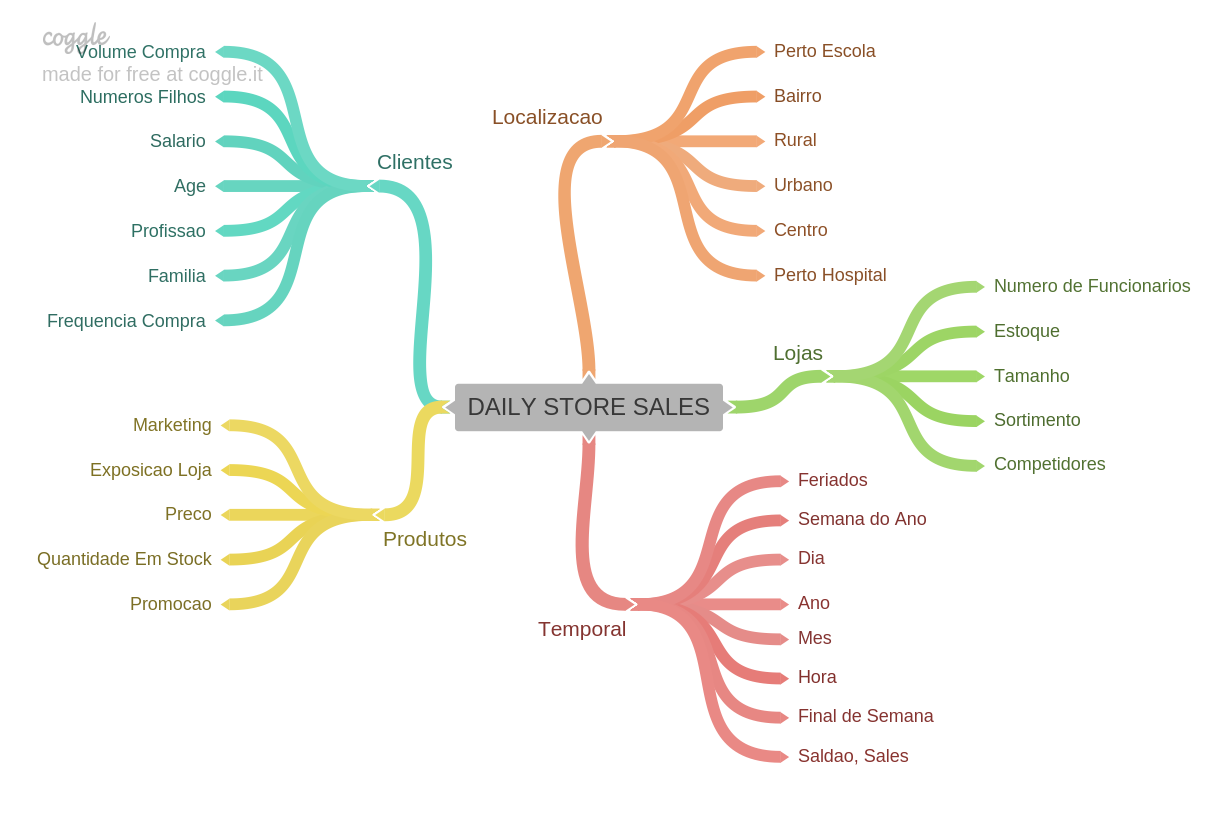

In [29]:
Image ('../img/mindmap.png')

### Criação das Hipóteses

#### As Hipóteses Loja
1 Lojas com numero maior de funcionarios deveriam vender mais. (Não temos o numero de funcionario neste momento)

2 Lojas com maior capacidade de estoque deveriam vender mais. (Não temos a informação do estoque)

3 Lojas com maior porte deveriam vender mais. (Não temos o tamanho da loja)

4 Lojas com maior sortimento deveriam vender mais.

5 Lojas com competidores mais proximos deveriam vender menos.

6 Lojas com competidores a mais tempo deveriam vender mais.


#### As Hipoteses Produto
1 Lojas que investem mais em Marketing deveriam vender mais. (Não temos essa informação)

2 Lojas com maior exposição de produto deveria vender mais. (Não temos a quantidade de produtos)

3 Lojas com produtos e preço menor deveria vender mais. (Não temos os preços dos produtos)

4 Lojas com promoçoes mais agressivas (desconto maiores), deveriam vender mais.

5 Lojas com promoções ativas por mais tempo deveriam vender mais.

6 Lojas com mais dias de promoção deveriam vender mais.

7 Lojas com mais promoções consecutivas deveriam vender mais.


#### Hipotese Tempo
1 Lojas aberta durante o feriado de Natal deveriam vender mais.

2 Lojas deveriam vender mais .

3 Lojas deveriam vender mais no segundo semestre do ano.

4 Lojas deveriam vender mais depois do dia 10 de cada mes.

5 Lojas deveriam vender menos aos finais de semana.

6 Lojas deveriam vender menos durante os feriados escolares.


#### Lista final de Hipóteses


1 Lojas com maior sortimento deveriam vender mais.

2 Lojas com competidores mais proximos deveriam vender menos.

3 Lojas com competidores a mais tempo deveriam vender mais.

4 Lojas com promoções ativas por mais tempo deveriam vender mais.

5 Lojas com mais dias de promoção deveriam vender mais.

6 Lojas com mais promoções consecutivas deveriam vender mais.

7 Lojas abertas durante o feriado de Natal deveriam vender mais.

8 Lojas deveriam vender mais ao longo dos anos.

9 Lojas deveriam vender mais no segundo semestre do ano.

10 Lojas deveriam vender mais depois do dia 10 de cada mes.

11 Lojas deveriam vender menos aos finais de semana.

12 Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [30]:
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
"""
criando a competition_since, que é a junção competition_open_since_year e competition_time_month.
day=1 visto que só tenho o ano e o mẽs, vou colocar todo o dia primeiro de cada mês e vou considerar o mês como um todo.
"""

df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], 
                                                           month=x['competition_open_since_month'], day=1), axis=1)

# tempo desde que a competição começou em meses, convertidos em numeros inteiros
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

# promo since
# ano - semana do ano
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# subscrevendo a promo_since e convertendo para datetime
df2['promo_since'] = df2['promo_since'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )
# o tempo em que a promoção está ativa em semanas. 
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
# Transformando os níveis de sortimento ('a', 'b', 'c') em categorias mais descritivas ('basic', 'extra', 'extended')
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# # Transformando os tipos de feriados ('a', 'b', 'c') em categorias mais descritivas ('public_holiday', 'easter_holiday', 'christmas')
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# `FILTRAGEM DE VARIÁVEIS`

In [32]:
df3 = df2.copy()

## Filtragem das Linhas

In [33]:
# Não considerar as lojas que estão fechadas.
# Não considerar sales = 0
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]

## Seleção das Colunas

In [34]:
"""
# Drop de colunas:

- restrição de negocio, não tem como mensurar a quantidade de customers no nomemnto, apenas em um projeto a parte
- a coluna 'open' sem variabilidade, contendo apenas '1'
- a coluna 'promo_interval' derivou a 'is_promo'
- a coluna 'month_map' foi utilizada como auxiliar
"""

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## Data Fields 2

| **Coluna**                       | **Descrição**                                                                                                                   |
|:-------------------------------- |:------------------------------------------------------------------------------------------------------------------------------- |
| **store**                        | Um ID exclusivo para cada loja                                                                                                  |
| **day_of_week**                  | Indica o dia da semana                                                                                                          |
| **date**                         | Data do registro                                                                                                                |
| **sales**                        | Faturamento da loja naquele dia                                                                                                 |
| **promo**                        | Indica se uma loja está executando uma promoção naquele dia: 0 = a loja não está participando, 1 = a loja está participando.                                                                    |
| **state_holiday**                | Indica um feriado estadual. ('public_holiday', 'easter_holiday', 'christmas')                                                   |
| **school_holiday**               | Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas                                                        |
| **store_type**                   | Indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)                                                                   |
| **assortment**                   | Descreve um nível de sortimento: básico, extra, estendido                                                                       |
| **competition_distance**         | Distância em metros até a loja concorrente mais próxima                                                                         |
| **competition_open_since_month** | Fornece o mês aproximado em que o concorrente mais próximo foi aberto                                                           |
| **competition_open_since_year**  | Fornece o ano aproximado em que o concorrente mais próximo foi aberto                                                           |
| **promo2**                       | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando |
| **promo2_since_week**            | Descreve a semana do calendário em que a loja começou a participar do Promo2                                                    |
| **promo2_since_year**            | Descreve o ano do calendário em que a loja começou a participar do Promo2                                                       |
| **is_promo**                     | Indica se uma promoção está ocorrendo no mês correspondente. 0 = Não, 1 = Sim.                                                  |
| **year**                         | Ano                                                                                                                             |
| **month**                        | Mês                                                                                                                             |
| **day**                          | Dia                                                                                                                             |
| **week_of_year**                 | Semana do ano                                                                                                                   |
| **year_week**                    | Ano e Semana                                                                                                                    |
| **competition_since**            | Tempo desde que a competição começou. Junção competition_open_since_year e competition_open_since_month                         |
| **competition_time_month**       | Tempo desde que a competição começou em meses, convertidos em números inteiros                                                  |
| **promo_since**                  | Data que iniciou a promoção.                                                                                                    |
| **promo_time_week**              | O tempo em que a promoção está ativa em semanas                                                                                 |


In [35]:
# Dicionário 
info = {
    "store": "Um ID exclusivo para cada loja",
    "day_of_week": "Indica o dia da semana",
    "date": "Data do registro",
    "sales": "Faturamento da loja naquele dia",
    "promo": "promo Indica se uma loja está executando uma promoção naquele dia: 0 = a loja não está participando, 1 = a loja está participando.",
    "state_holiday":  "Indica um feriado estadual. ('public_holiday', 'easter_holiday', 'christmas')",
    "school_holiday": "Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas",
    "store_type": "Indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)",
    "assortment": "Descreve um nível de sortimento: básico, extra, estendido",
    "competition_distance": "Distância em metros até a loja concorrente mais próxima",
    "competition_open_since_month": "Fornece o mês aproximado em que o concorrente mais próximo foi aberto",
    "competition_open_since_year": "Fornece o ano aproximado em que o concorrente mais próximo foi aberto",
    "promo2": "Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando",
    "promo2_since_week": "Descreve a semana do calendário em que a loja começou a participar do Promo2",
    "promo2_since_year": "Descreve o ano do calendário em que a loja começou a participar do Promo2",
    "is_promo": "Indica se uma promoção está ocorrendo no mês correspondente. 0 = Não, 1 = Sim.",
    "year": "Ano",
    "month": "Mês",
    "day": "Dia",
    "week_of_year": "Semana do ano",
    "year_week": "Ano e Semana",
    "competition_since": "Tempo desde que a competição começou. Junção competition_open_since_year e competition_open_since_month",
    "competition_time_month": "Tempo desde que a competição começou em meses, convertidos em números inteiros",
    "promo_since": "Data que iniciou a promoção.",
    "promo_time_week": "O tempo em que a promoção está ativa em semanas"
}


# `EDA`

In [36]:
df4 = df3.copy()

## Analise `Univariada` 

### Variável Resposta

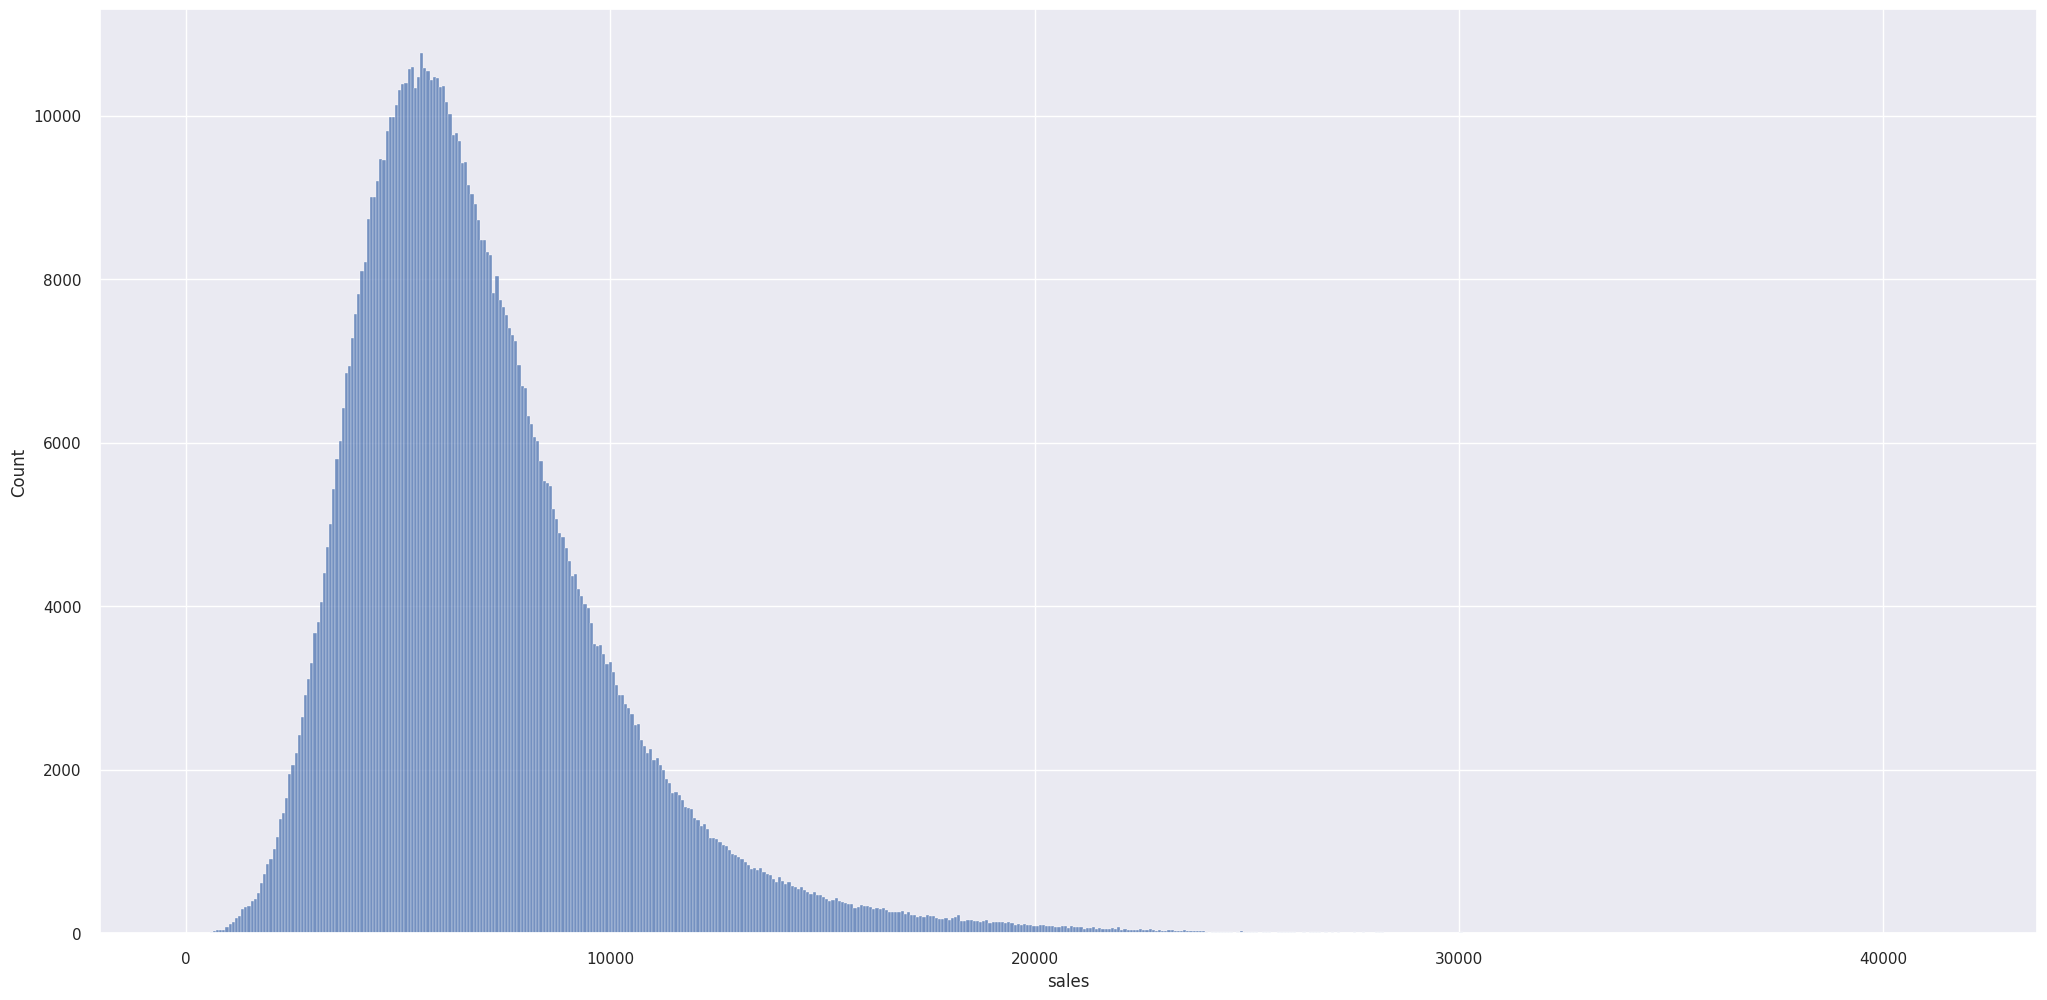

In [37]:
sns.histplot(df4['sales']);

In [38]:
m.iloc[2:3], ss.mode(df4['sales'])

(  attributes  min      max    range         mean  median          std     skew  kurtosis
 2      sales  0.0  41551.0  41551.0  5773.818972  5744.0  3849.924283  0.64146  1.778375,
 ModeResult(mode=5674, count=215))

### Variáveis Numéricas

In [39]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


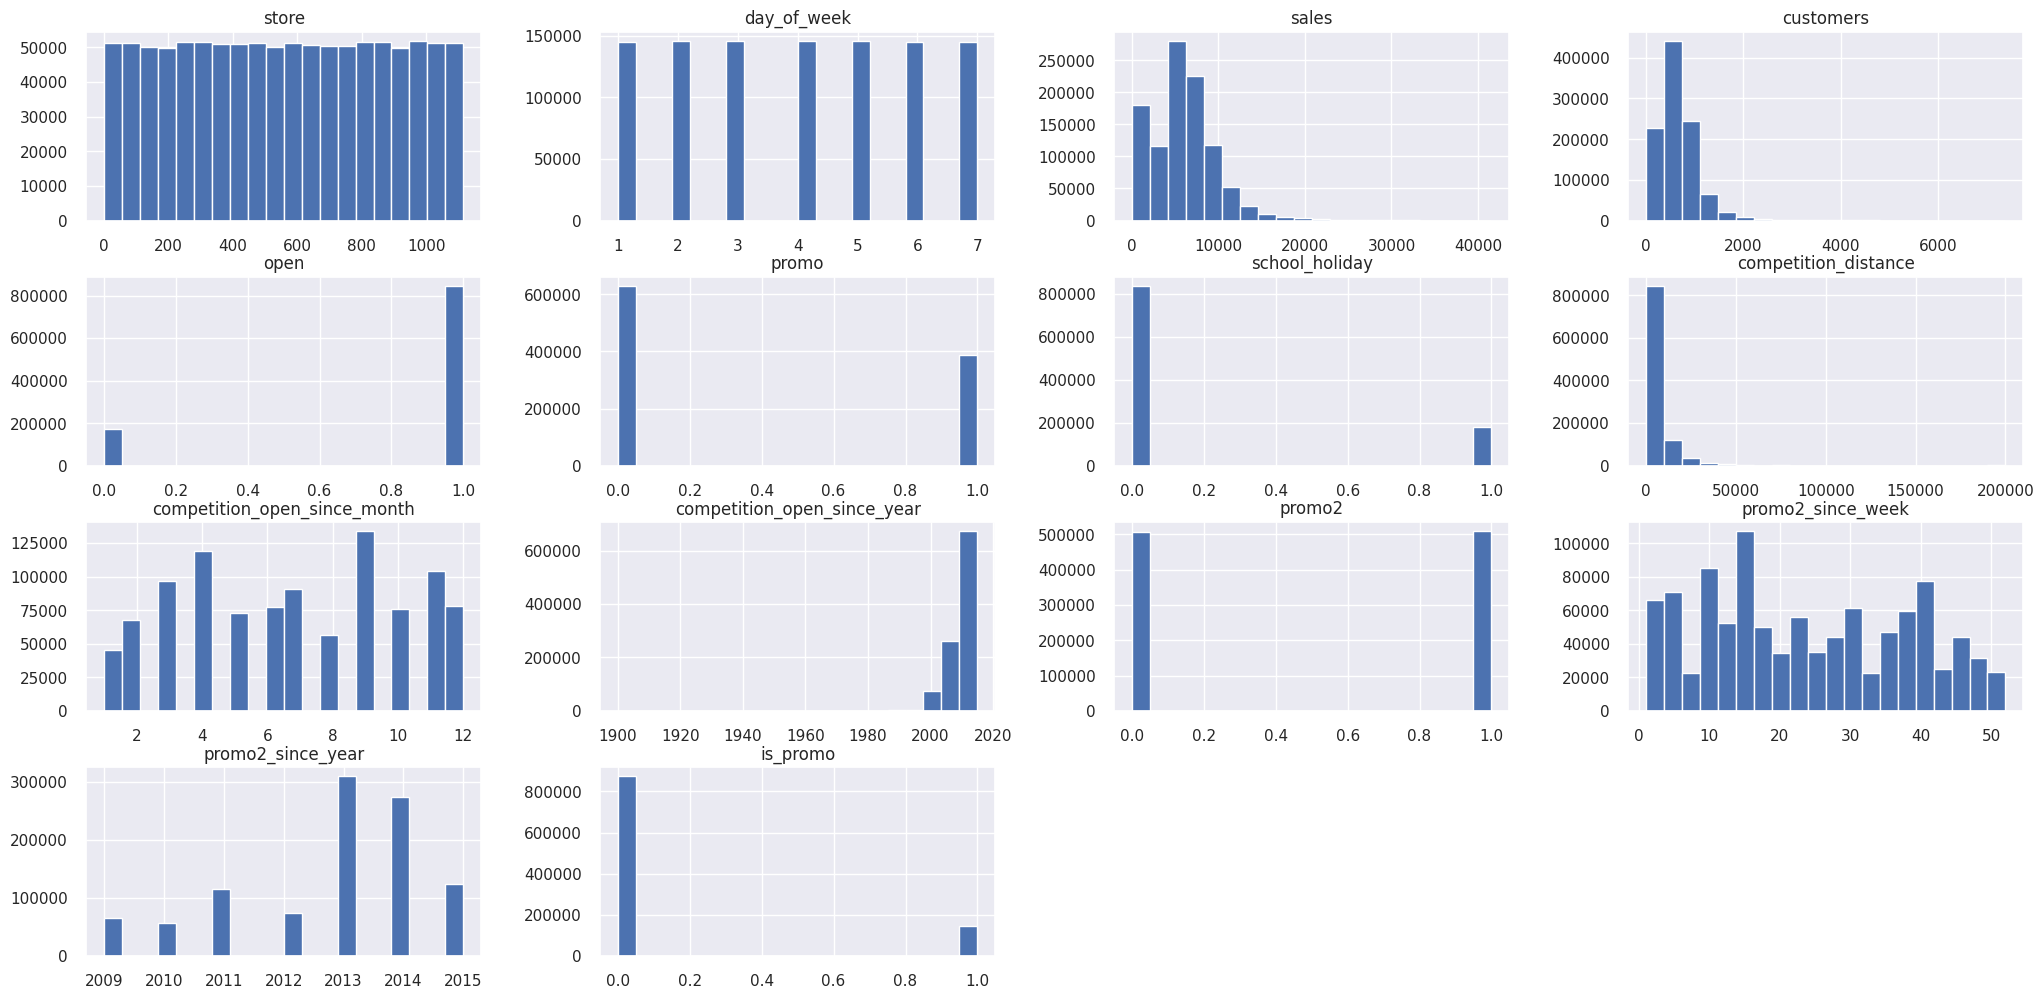

In [40]:
num_attributes.hist(bins=20);

### Variáveis Categoricas 

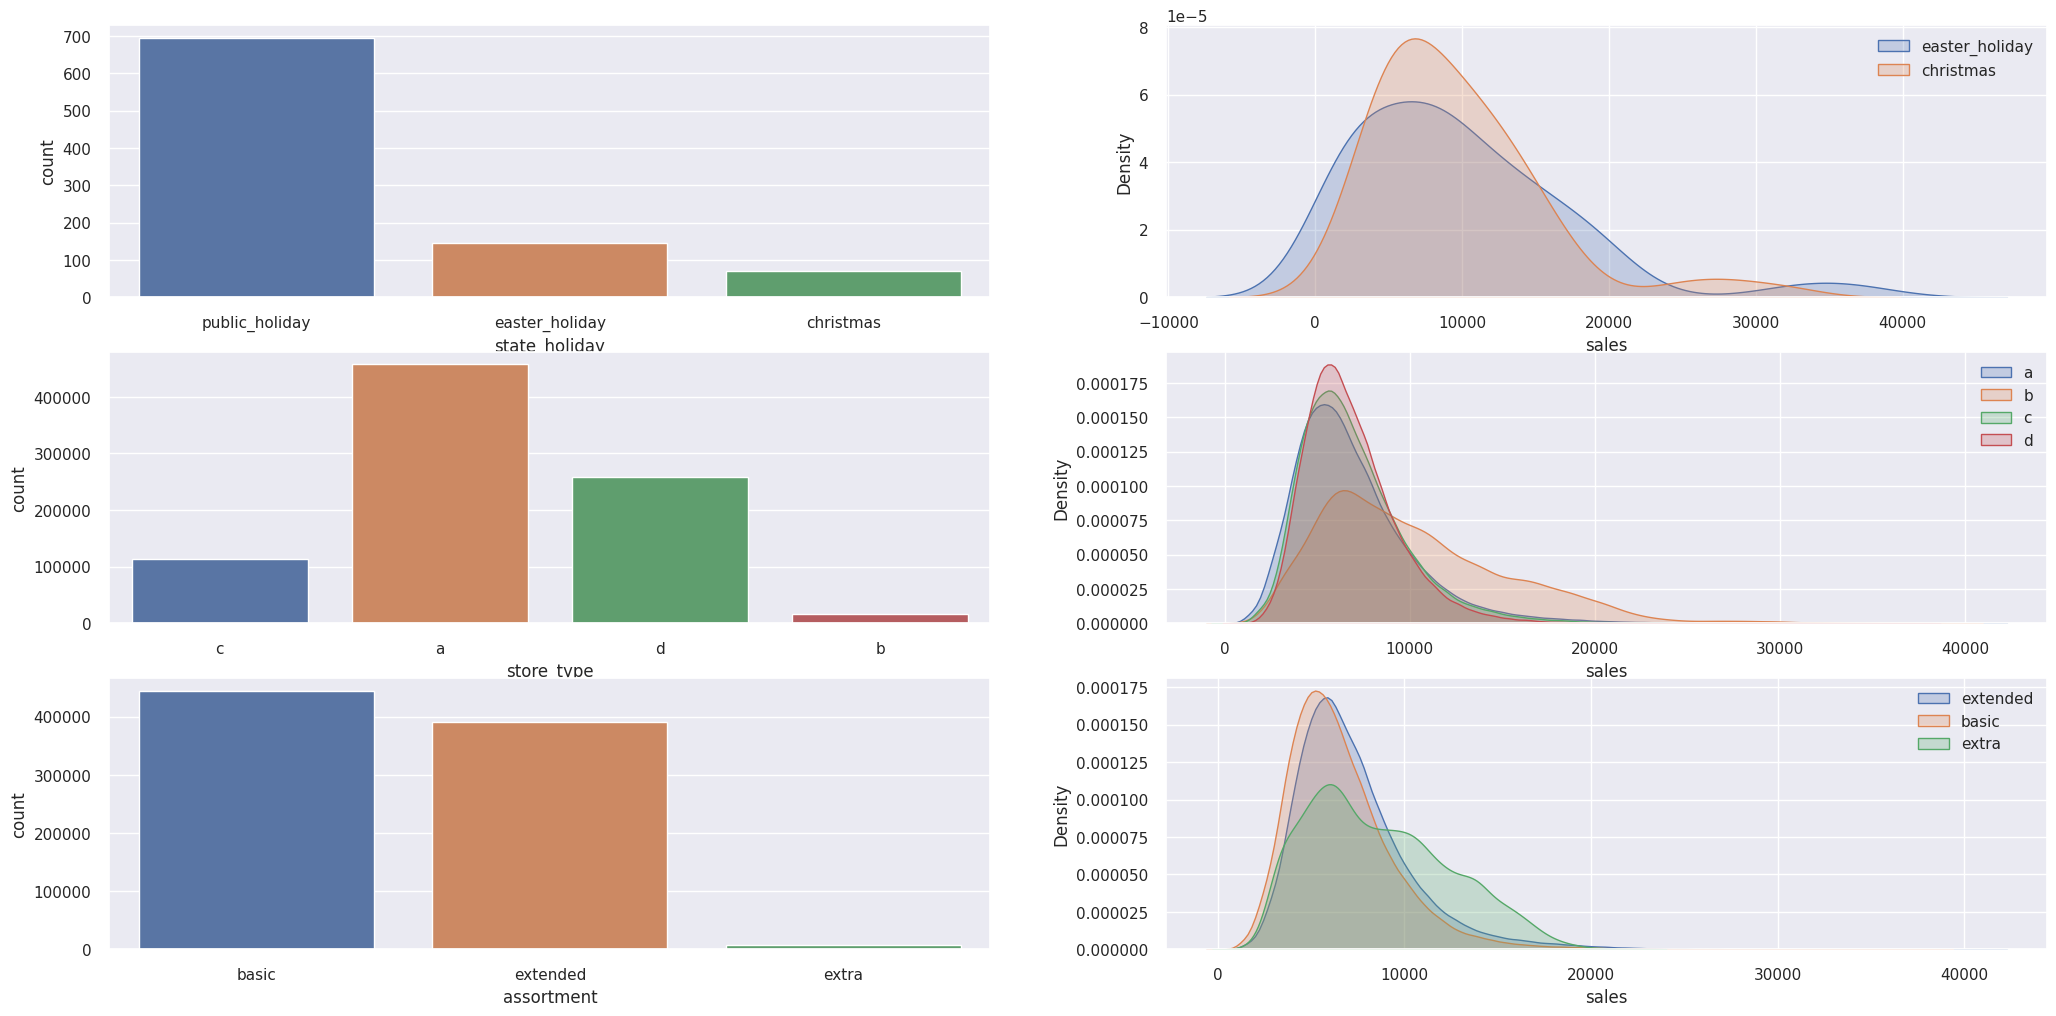

In [41]:
# state_holiday
# Primeiro subgráfico: Contagem de feriados estaduais
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day'] # Filtra os dados para excluir 'regular_day'
sns.countplot(a['state_holiday']) # Cria um gráfico de barras para os feriados estaduais


# Segundo subgráfico: Distribuição das vendas em diferentes feriados
plt.subplot(3, 2, 2)
# Plota a distribuição das vendas para feriados públicos
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True) # Plota a distribuição das vendas para feriados de Páscoa
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],      label='christmas',      shade=True) # Plota a distribuição das vendas para o Natal
plt.legend()

# store_type
# Terceiro subgráfico: Contagem de tipos de lojas
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])
  

# Quarto subgráfico: Distribuição das vendas por tipo de loja
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
# Quinto subgráfico: Contagem de sortimentos
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

# Sexto subgráfico: Distribuição das vendas por tipo de sortimento
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True) # distribuição das vendas para sortimento estendido
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],    label='basic',    shade=True) # distribuição das vendas para sortimento básico
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],    label='extra',    shade=True) # distribuição das vendas para sortimento extra
plt.legend()

## Análise `Bivariada`

### `H1`.Lojas com maior sortimento deveriam vender mais.

##### **`FALSA`** Lojas com MAIOR SORTIMENTO vendem MENOS.
- OBS.: Assumindo que o sortimento extra seja o maior dentre os sortimentos.

In [42]:
info['assortment']

'Descreve um nível de sortimento: básico, extra, estendido'

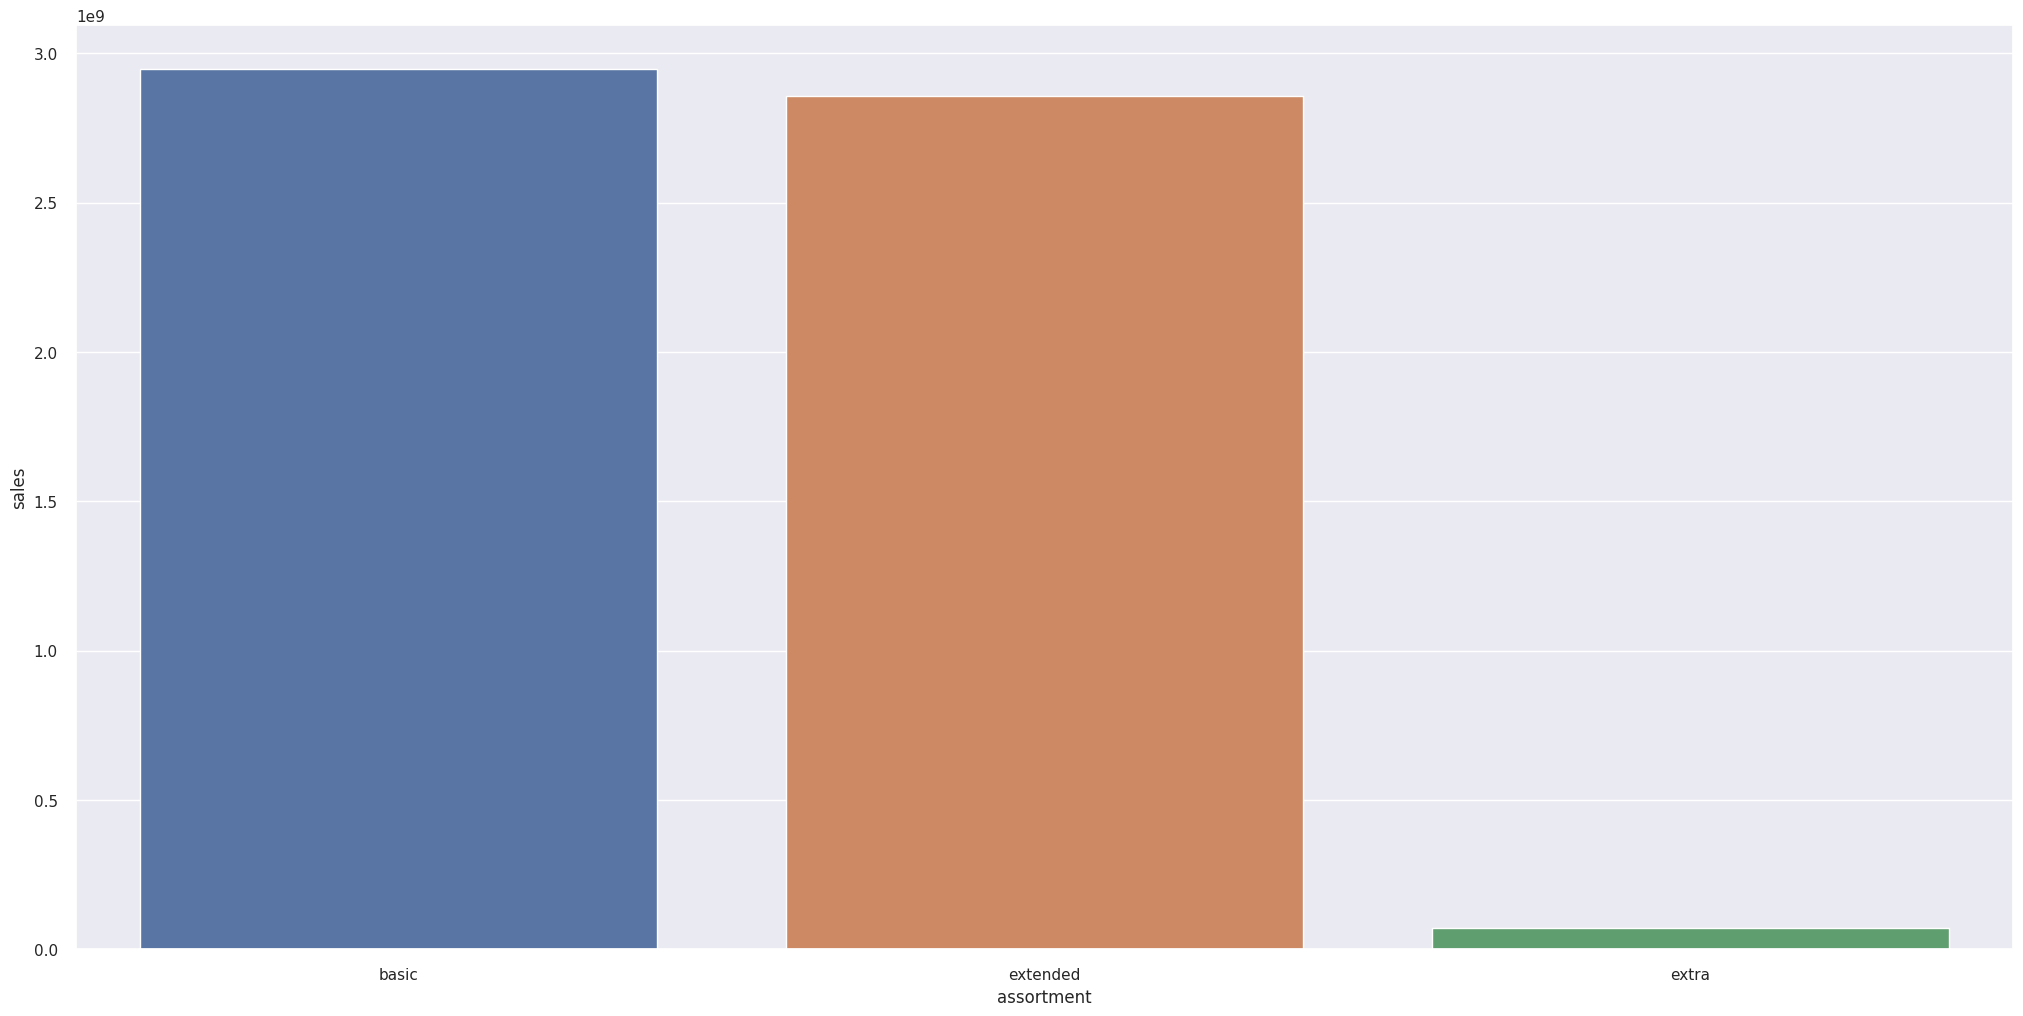

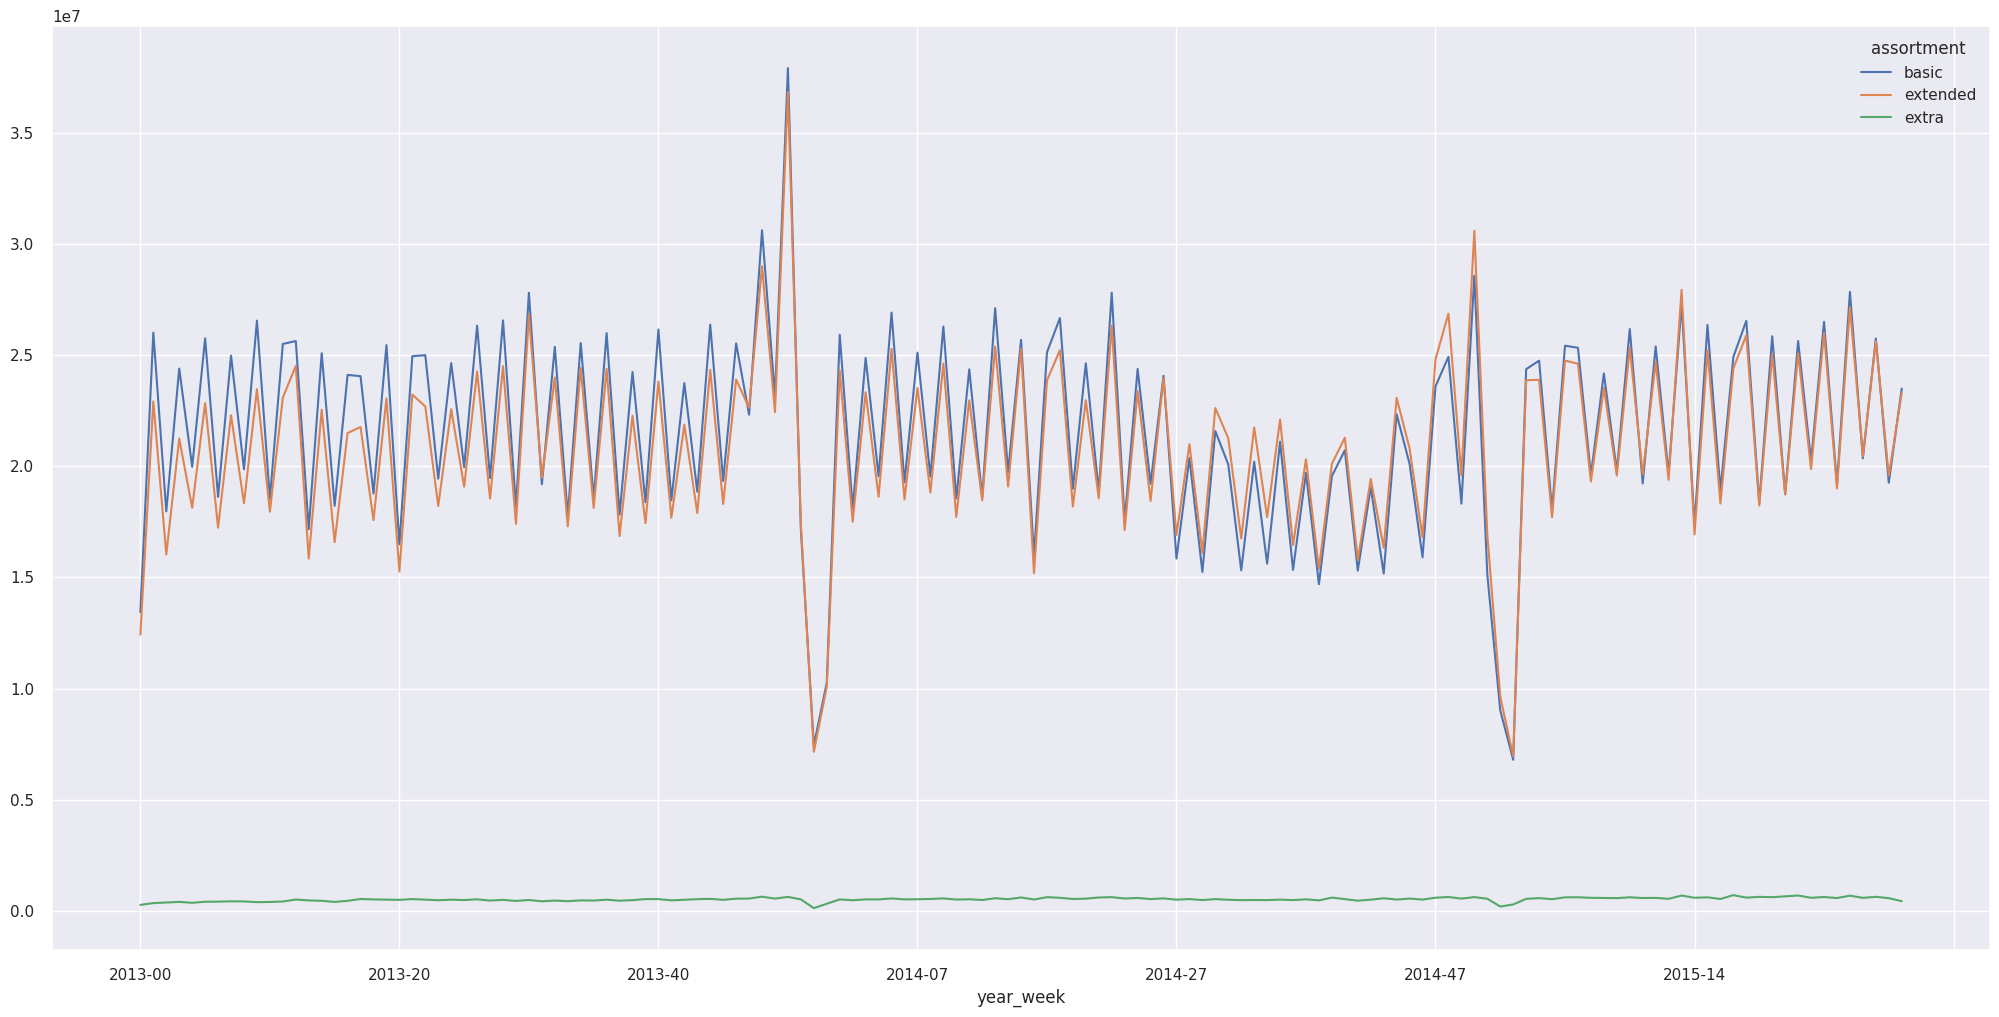

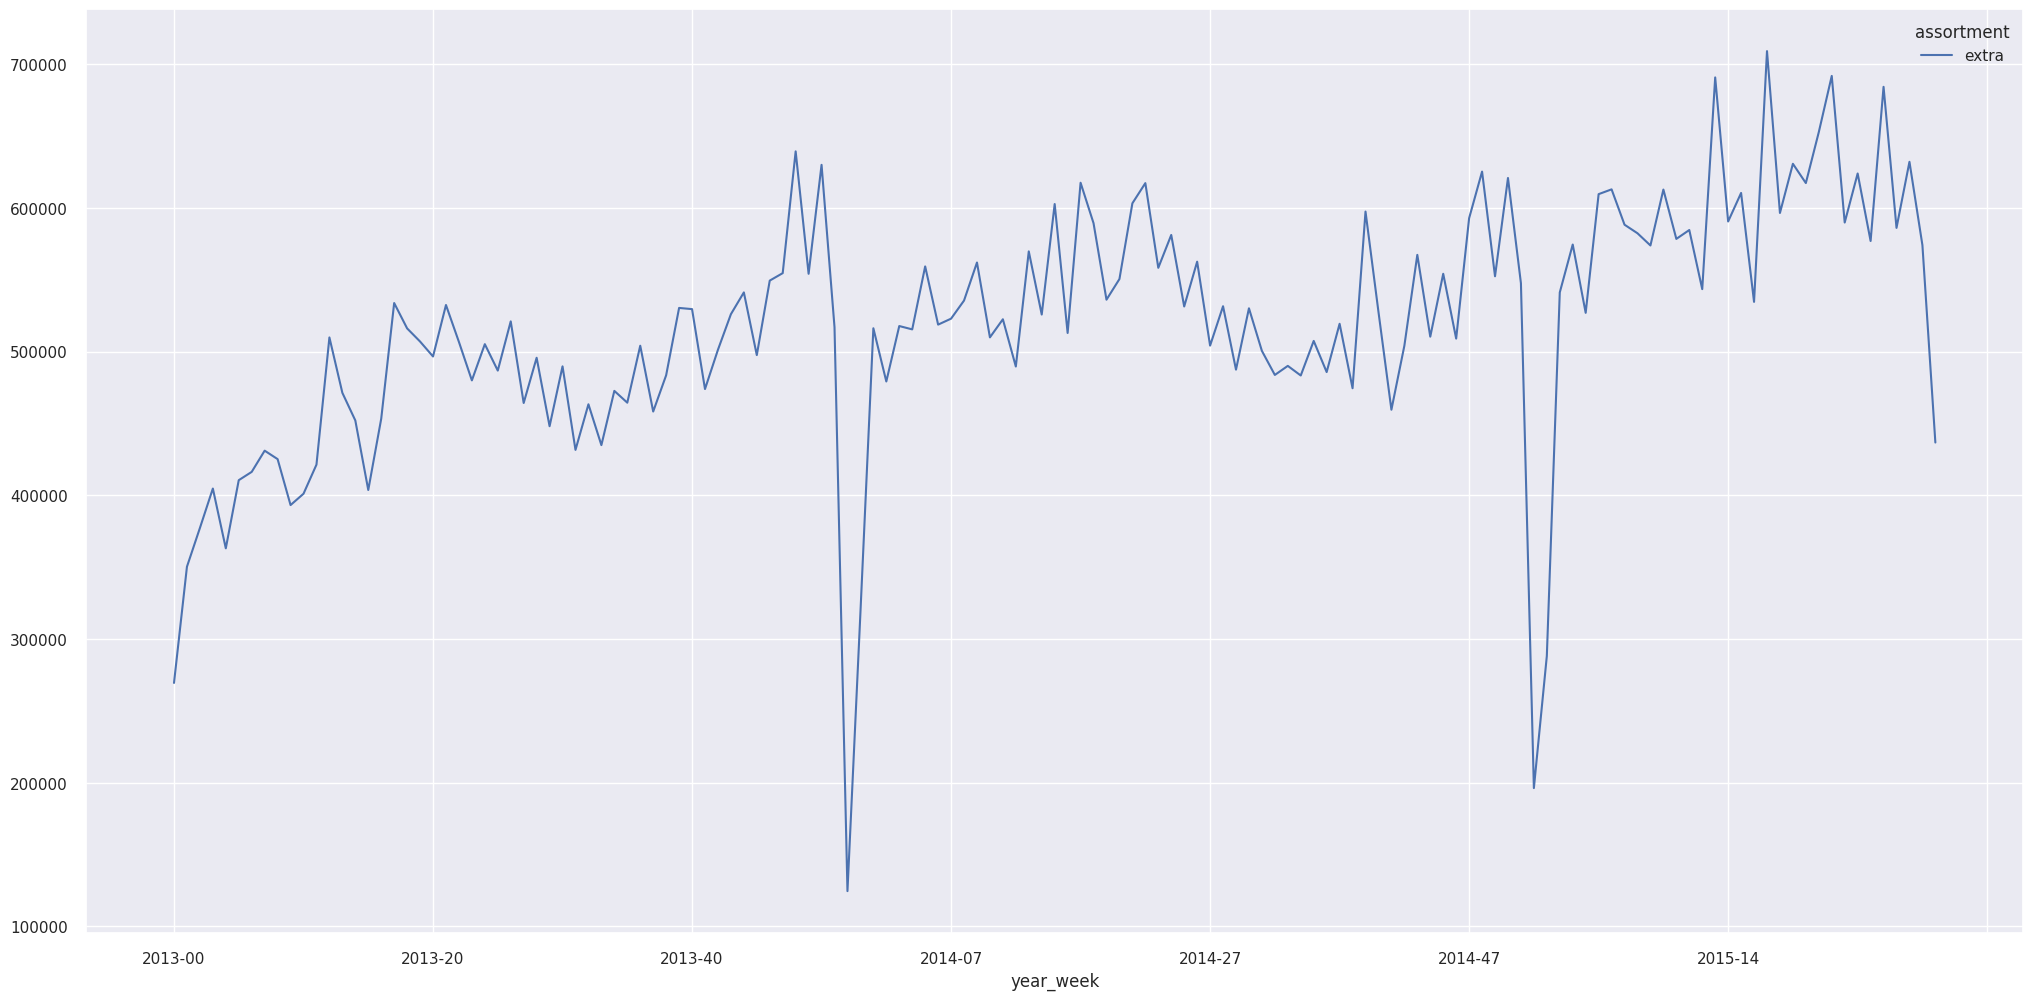

In [43]:
# Agrupar os dados de vendas pelo tipo de sortimento, somando as vendas para cada tipo
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Agrupar os dados pelas semanas do ano e tipo de sortimento, somando as vendas para cada combinação
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# Plotar um gráfico de linha mostrando as vendas semanais apenas para o sortimento 'extra'
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### `H2`.Lojas com competidores mais proximos deveriam vender menos.

##### **`FALSA`** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

In [44]:
info['competition_distance']

'Distância em metros até a loja concorrente mais próxima'

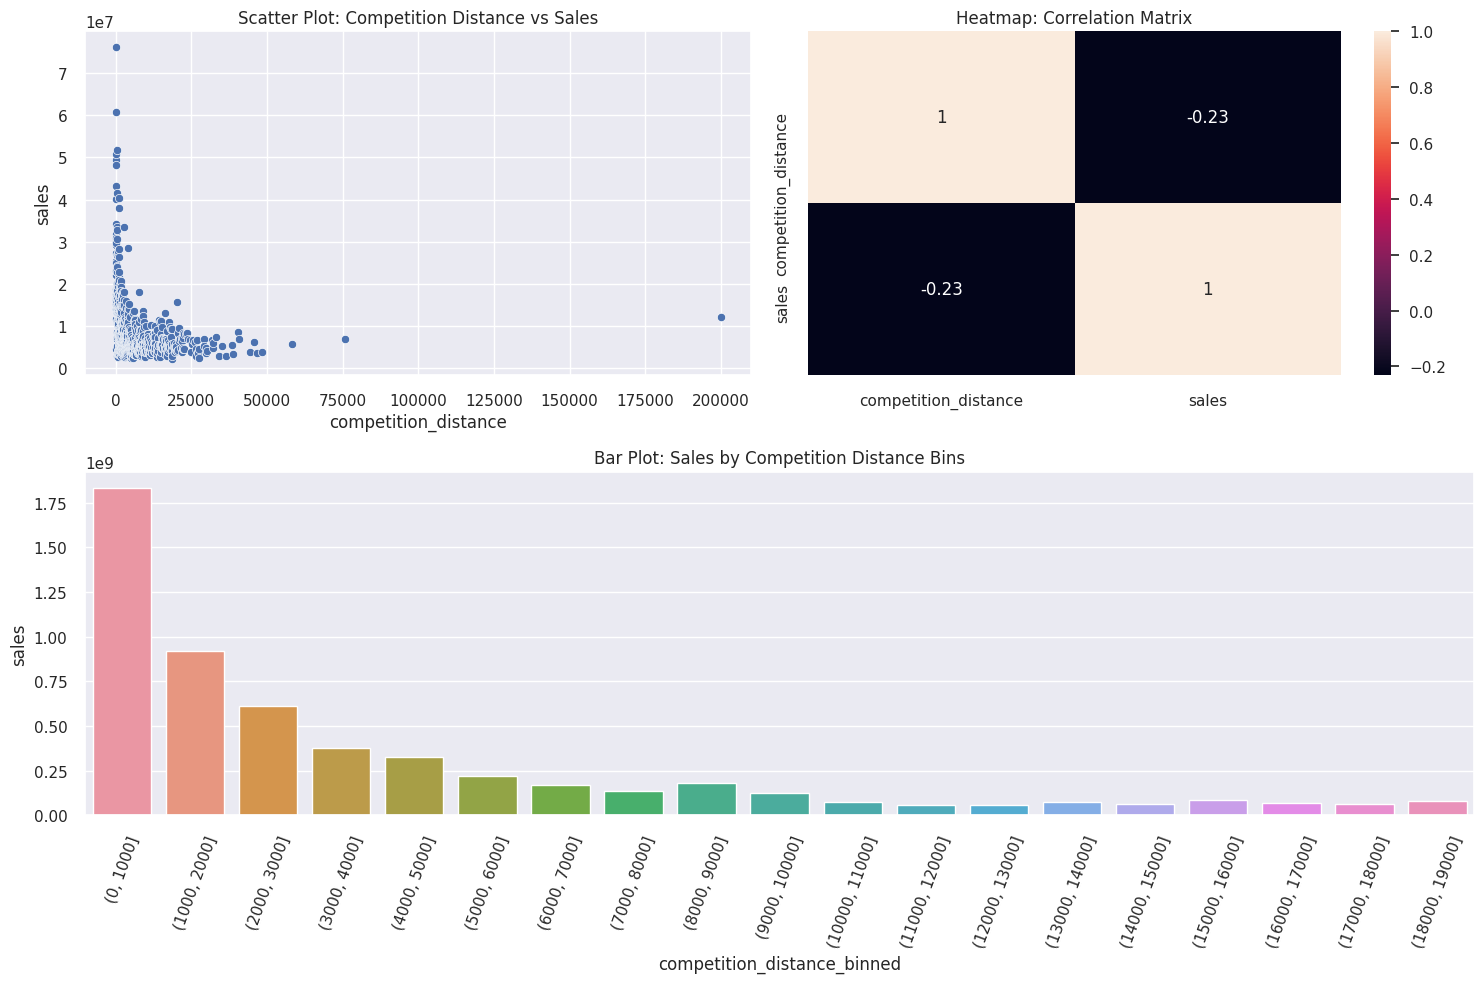

In [111]:
# Agrupar os dados por 'competition_distance' e somar as vendas ('sales') para cada distância de competição
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15, 10))

# Plotar o gráfico de dispersão entre 'competition_distance' e 'sales'
plt.subplot(221)
sns.scatterplot(x='competition_distance', y='sales', data=aux);
plt.title('Scatter Plot: Competition Distance vs Sales')

plt.subplot(212)
# Criar intervalos (bins) de 1000 em 1000 para 'competition_distance'
bins = list(np.arange(0, 20000, 1000))
# Adicionar uma nova coluna ao dataframe 'aux1' com os valores binned de 'competition_distance'
aux1['competition_distance_binned'] = pd.cut(aux['competition_distance'], bins=bins)
# Agrupar os dados por intervalos de 'competition_distance' e somar as vendas ('sales') para cada intervalo
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
# Plotar um gráfico de barras para as vendas ('sales') por intervalo de distância de competição
sns.barplot(x= 'competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=70);
plt.title('Bar Plot: Sales by Competition Distance Bins')


plt.subplot(222)
# Plotar a matriz de correlação entre 'competition_distance' e 'sales'
x = sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title('Heatmap: Correlation Matrix') 

plt.tight_layout()

### `H3`.Lojas com competidores a mais tempo deveriam vender mais.

##### **`FALSA`** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

In [46]:
info['competition_time_month']

'Tempo desde que a competição começou em meses, convertidos em números inteiros'

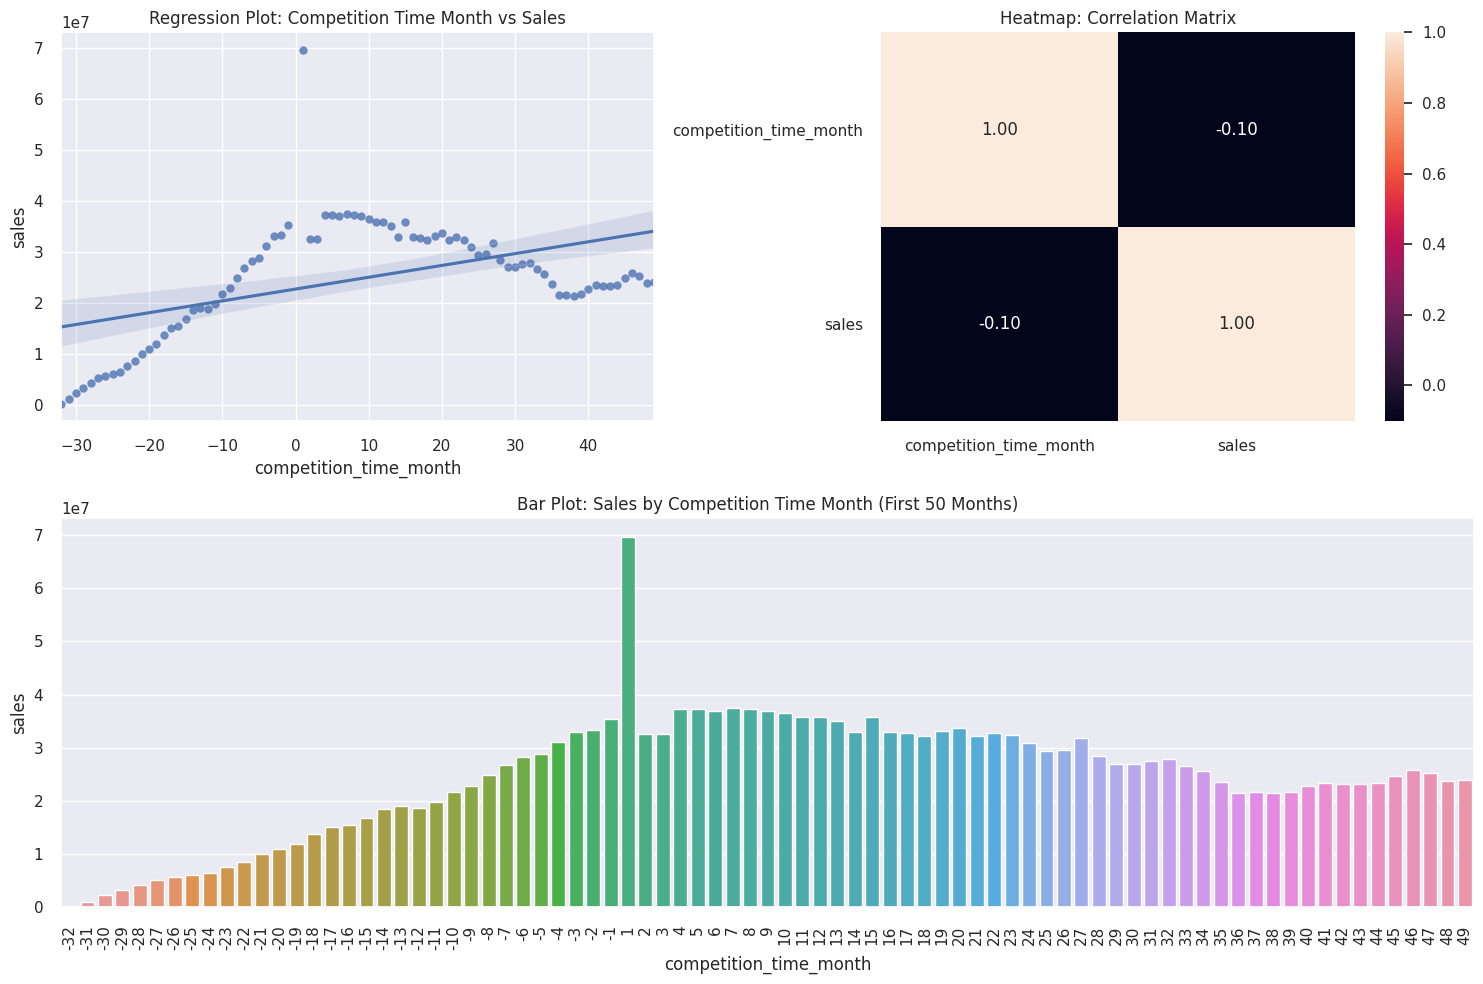

In [47]:
# Agrupar os dados por 'competition_time_month' e somar as vendas ('sales') para cada mês de competição
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.figure(figsize=(15, 10))

plt.subplot(212)
# filtrar apenas os 50 primeiros meses de competição e tempo de competição diferente de zero
aux2 = aux1[(aux1['competition_time_month'] < 50)  & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90)
plt.title('Bar Plot: Sales by Competition Time Month (First 50 Months)');

plt.subplot(221)
# Plotar um gráfico de regressão para mostrar a relação entre 'competition_time_month' e 'sales'
sns.regplot(x='competition_time_month', y='sales', data=aux2)
plt.title('Regression Plot: Competition Time Month vs Sales');

plt.subplot(222)
# Calcular a matriz de correlação entre 'competition_time_month' e 'sales'
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt='.2f')
plt.title('Heatmap: Correlation Matrix')

plt.tight_layout();

### `H4`.Lojas com promoções ativas por mais tempo deveriam vender mais.

##### `FALSA` Lojas com promoções ativas por MAIS TEMPO VENDEM MENOS, depois de um certo período de promoção.

In [48]:
info['promo_time_week']

'O tempo em que a promoção está ativa em semanas'

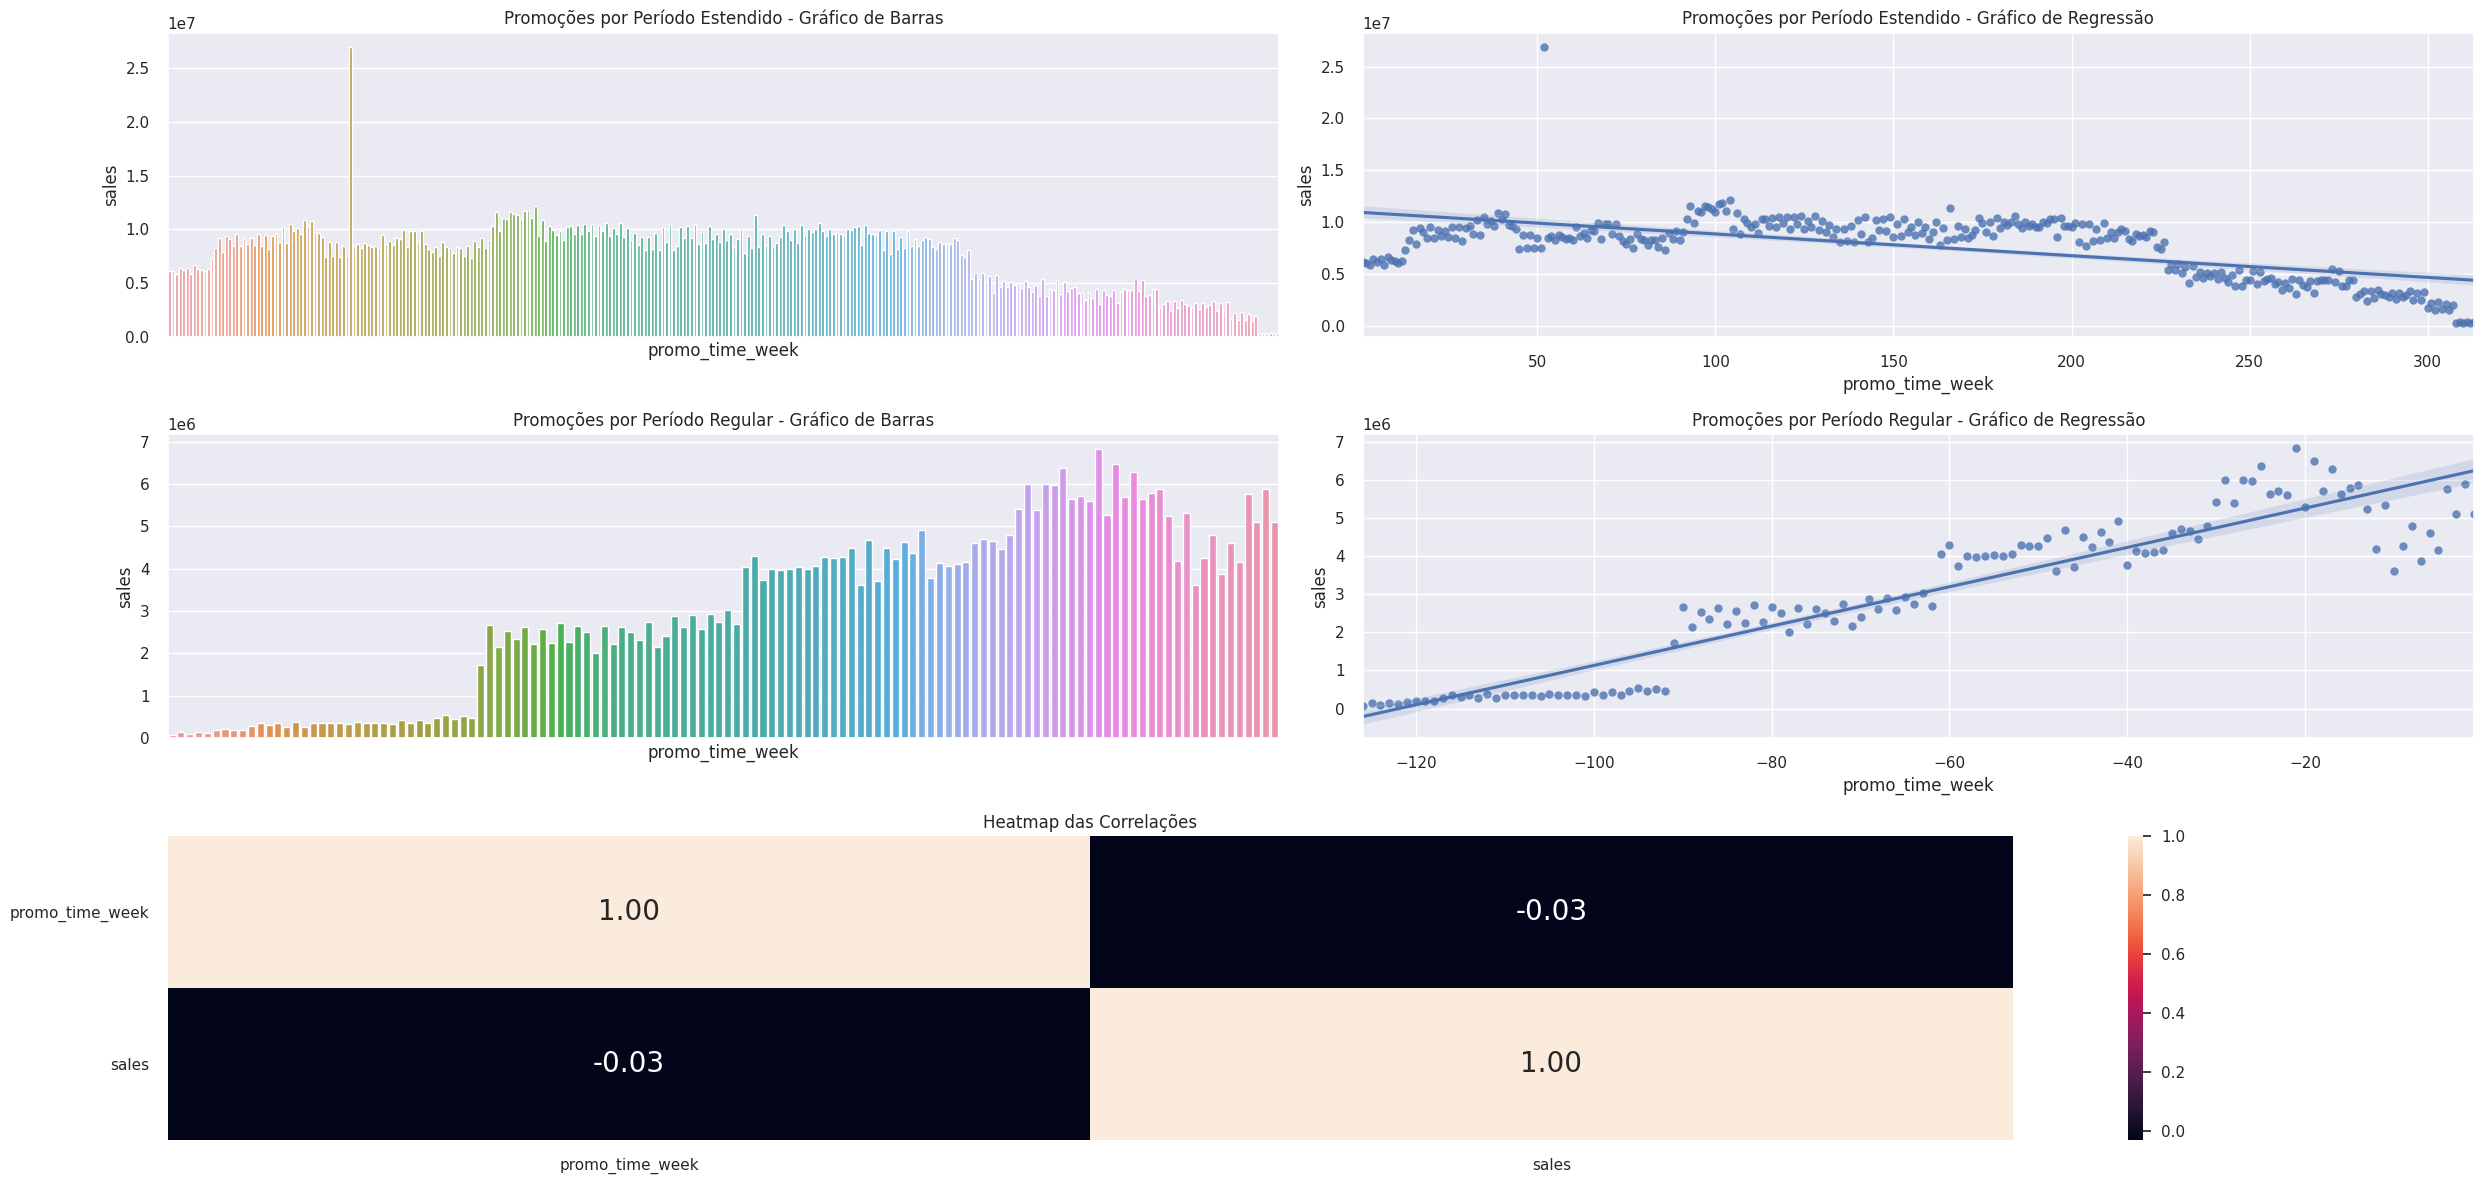

In [49]:
# Agrupar e somar vendas por semana de promoção
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(3, 2)

# Primeiro subplot: Gráfico de barras para promoções por período estendido
plt.subplot( grid[0, 0] )
aux2 =  aux1[aux1['promo_time_week'] > 0] # promoção por periodo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks([]) # Remover rótulos do eixo x
plt.title('Promoções por Período Estendido - Gráfico de Barras')

# Segundo subplot: Gráfico de regressão para promoções por período estendido
plt.subplot( grid[0, 1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Promoções por Período Estendido - Gráfico de Regressão')

# Terceiro subplot: Gráfico de barras para promoções por período regular
plt.subplot( grid[1, 0] )
aux3 =  aux1[aux1['promo_time_week'] < 0] # promoção por periodo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks([]) # Remover rótulos do eixo x
plt.title('Promoções por Período Regular - Gráfico de Barras')

# Quarto subplot: Gráfico de regressão para promoções por período regular
plt.subplot( grid[1,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Promoções por Período Regular - Gráfico de Regressão')

# Quinto subplot: Heatmap das correlações
plt.subplot(grid[2,:])
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt='.2f', annot_kws={"size": 20})
plt.title('Heatmap das Correlações')

plt.tight_layout();

### <s>`H5`.Lojas com mais dias de promoção deveriam vender mais.</s>

- A Hipótese 5, será analisada no próximo ciclo.

### `H6`.Lojas com mais promoções consecutivas deveriam vender mais.

##### **`FALSA`** Lojas com promoção consecutivas vendem menos

- Observamos que as lojas com promoções consecutivas vendem menos. Esse pode ser um insight importante para o negócio.

- Relevância para o modelo: baixa. Analisando essas variáveis isoladamente, elas não parecem ser muito relevantes para o modelo, pois há apenas uma pequena diferença no gráfico. Posteriormente, obteremos uma segunda opinião de um algoritmo.

In [50]:
info['promo'], info['promo2']

('promo Indica se uma loja está executando uma promoção naquele dia: 0 = a loja não está participando, 1 = a loja está participando.',
 'Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando')

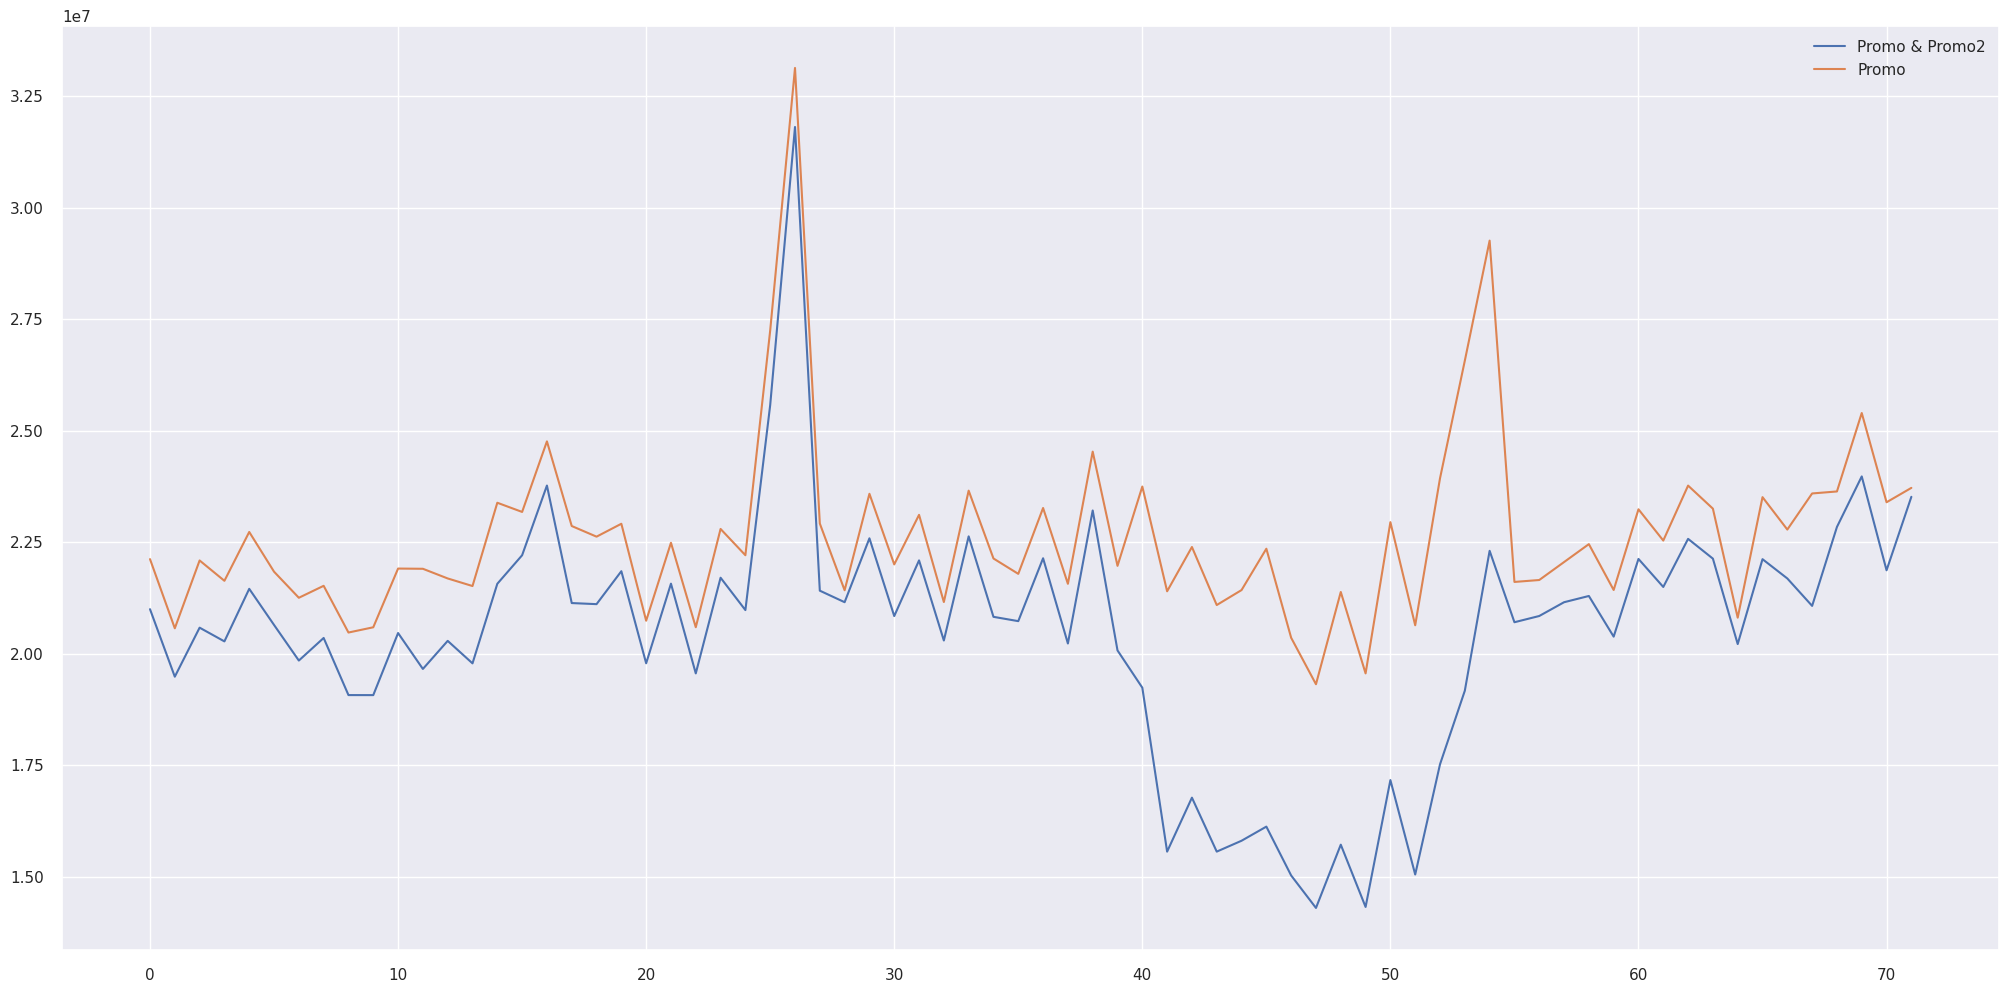

In [51]:
# Filtrar as lojas que estão participando do período promocional tradicional e extendido 
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# Filtrar as lojas que apenas participaram do período promocional tradicional 
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Promo & Promo2', 'Promo']);

### `H7`.Lojas abertas durante o feriado de natal deveriam vender mais.

##### **`FALSA`** Lojas abertas durante o feriado de Natal vendem menos.

In [52]:
info['state_holiday']

"Indica um feriado estadual. ('public_holiday', 'easter_holiday', 'christmas')"

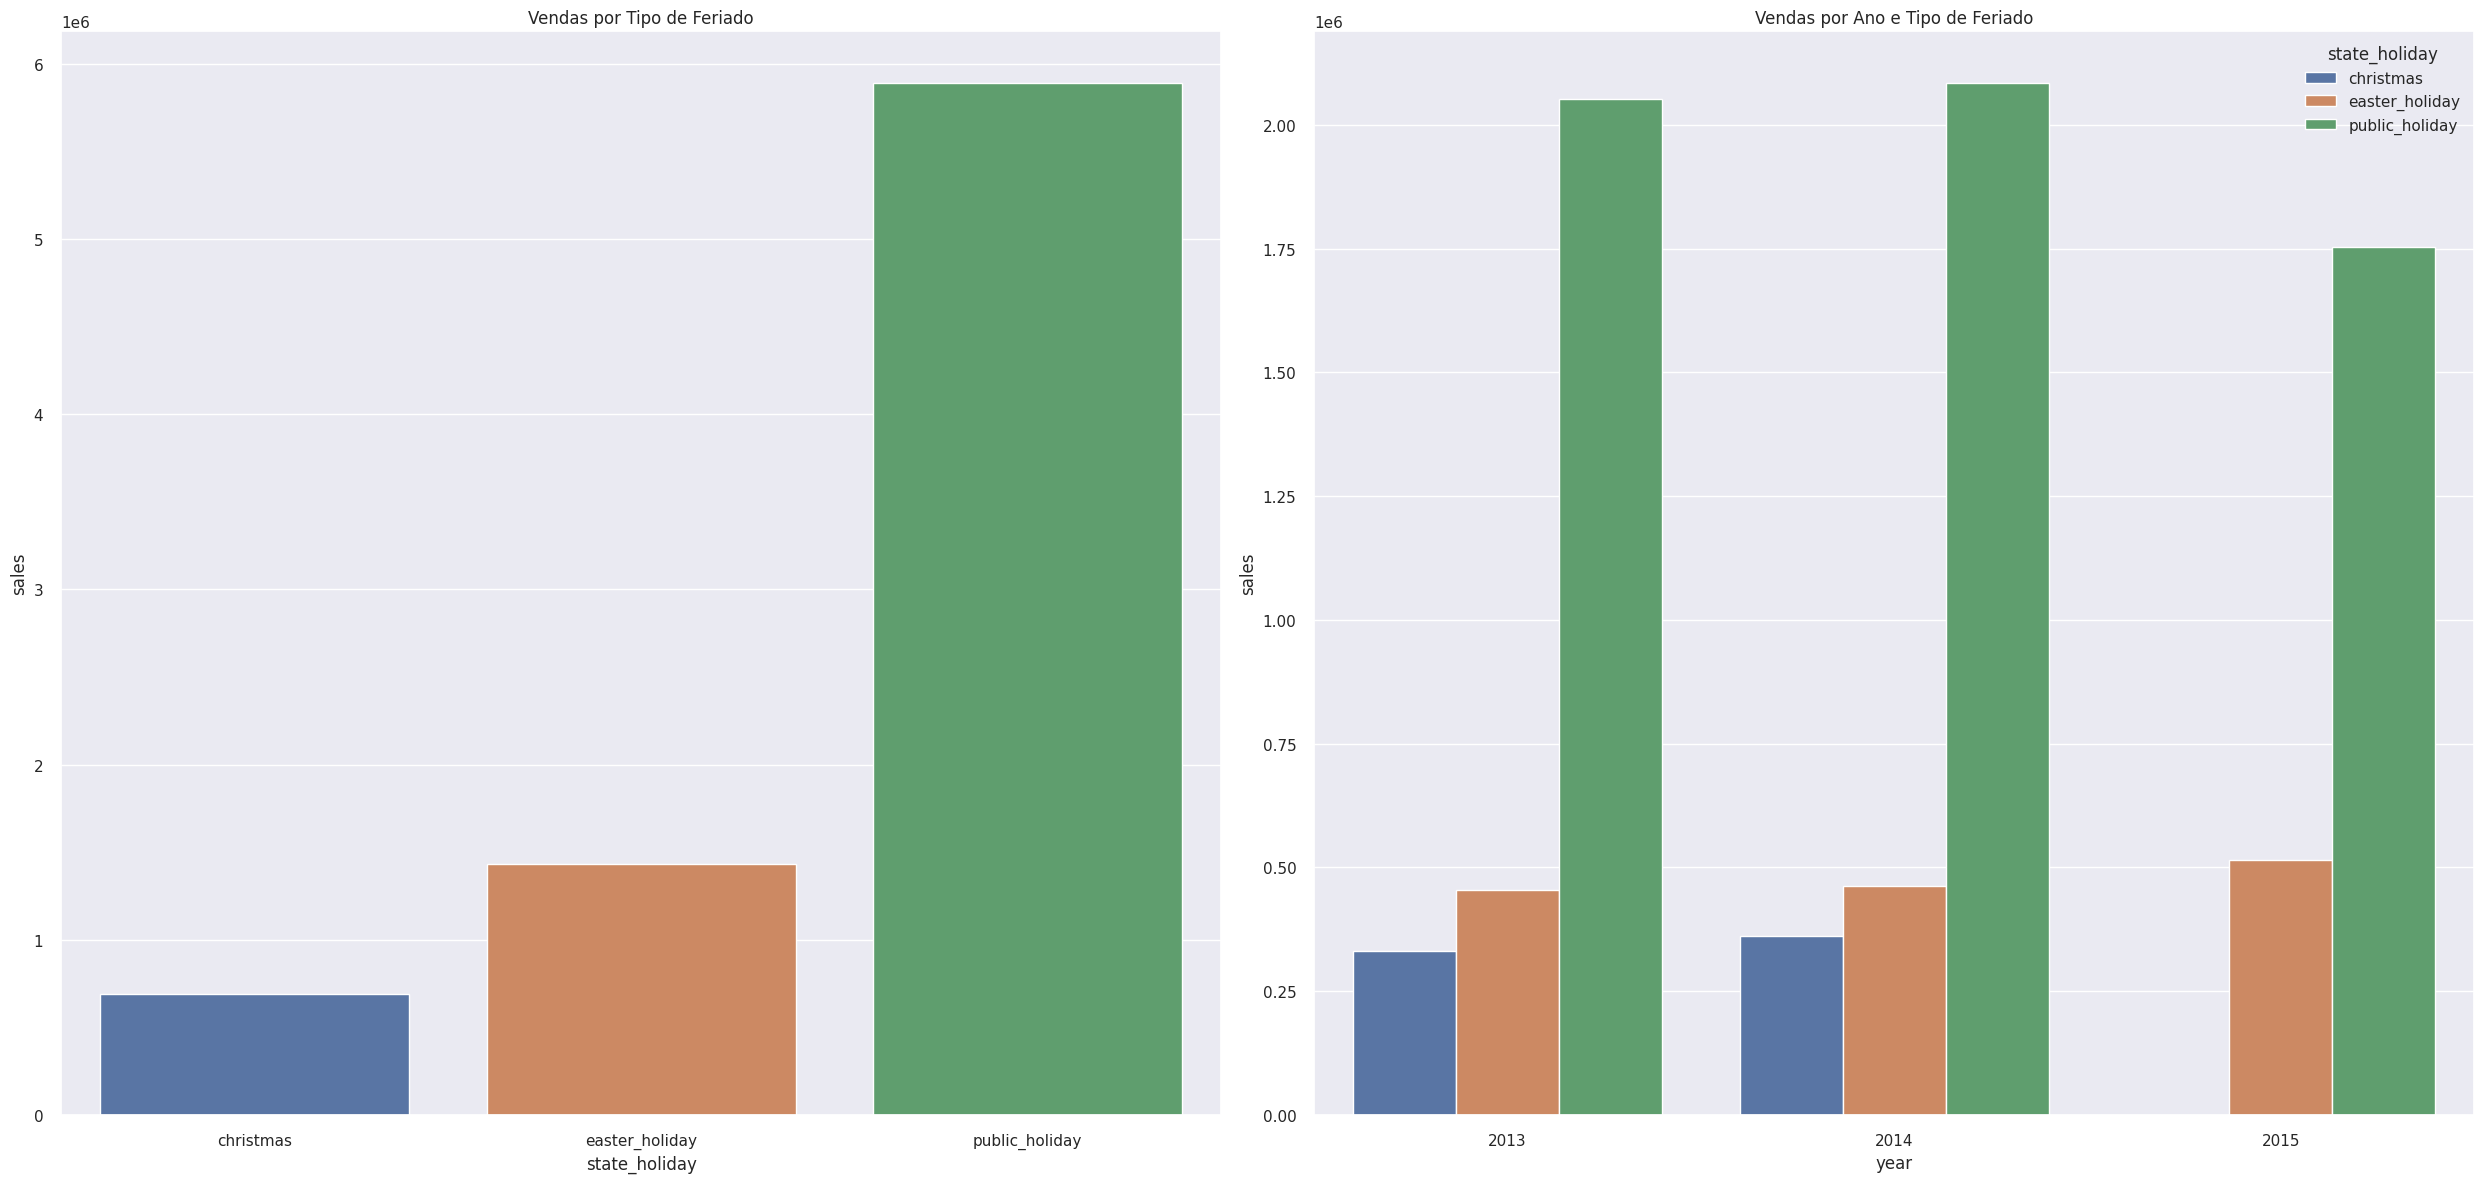

In [53]:
# Filtra o DataFrame para incluir apenas os dados de feriados (exclui 'regular_day')
aux = df4[df4['state_holiday'] != 'regular_day']

# Primeiro subplot: Vendas por Tipo de Feriado
plt.subplot(121)
# Agrupa os dados por tipo de feriado e soma as vendas
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
# Cria um gráfico de barras para mostrar a soma das vendas por tipo de feriado
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title('Vendas por Tipo de Feriado')

# Segundo subplot: Vendas por Ano e Tipo de Feriado
plt.subplot(122)
# Agrupa os dados por ano e tipo de feriado e soma as vendas
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
# Cria um gráfico de barras para mostrar a soma das vendas por ano e tipo de feriado
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2) # Dados até julho de 2015
plt.title('Vendas por Ano e Tipo de Feriado')

# Ajusta o layout dos subplots para evitar sobreposição
plt.tight_layout();


### `H8`.Lojas deveriam vender mais ao longo dos anos.

##### **`FALSA`** Lojas vendem menos ao longo dos anos.

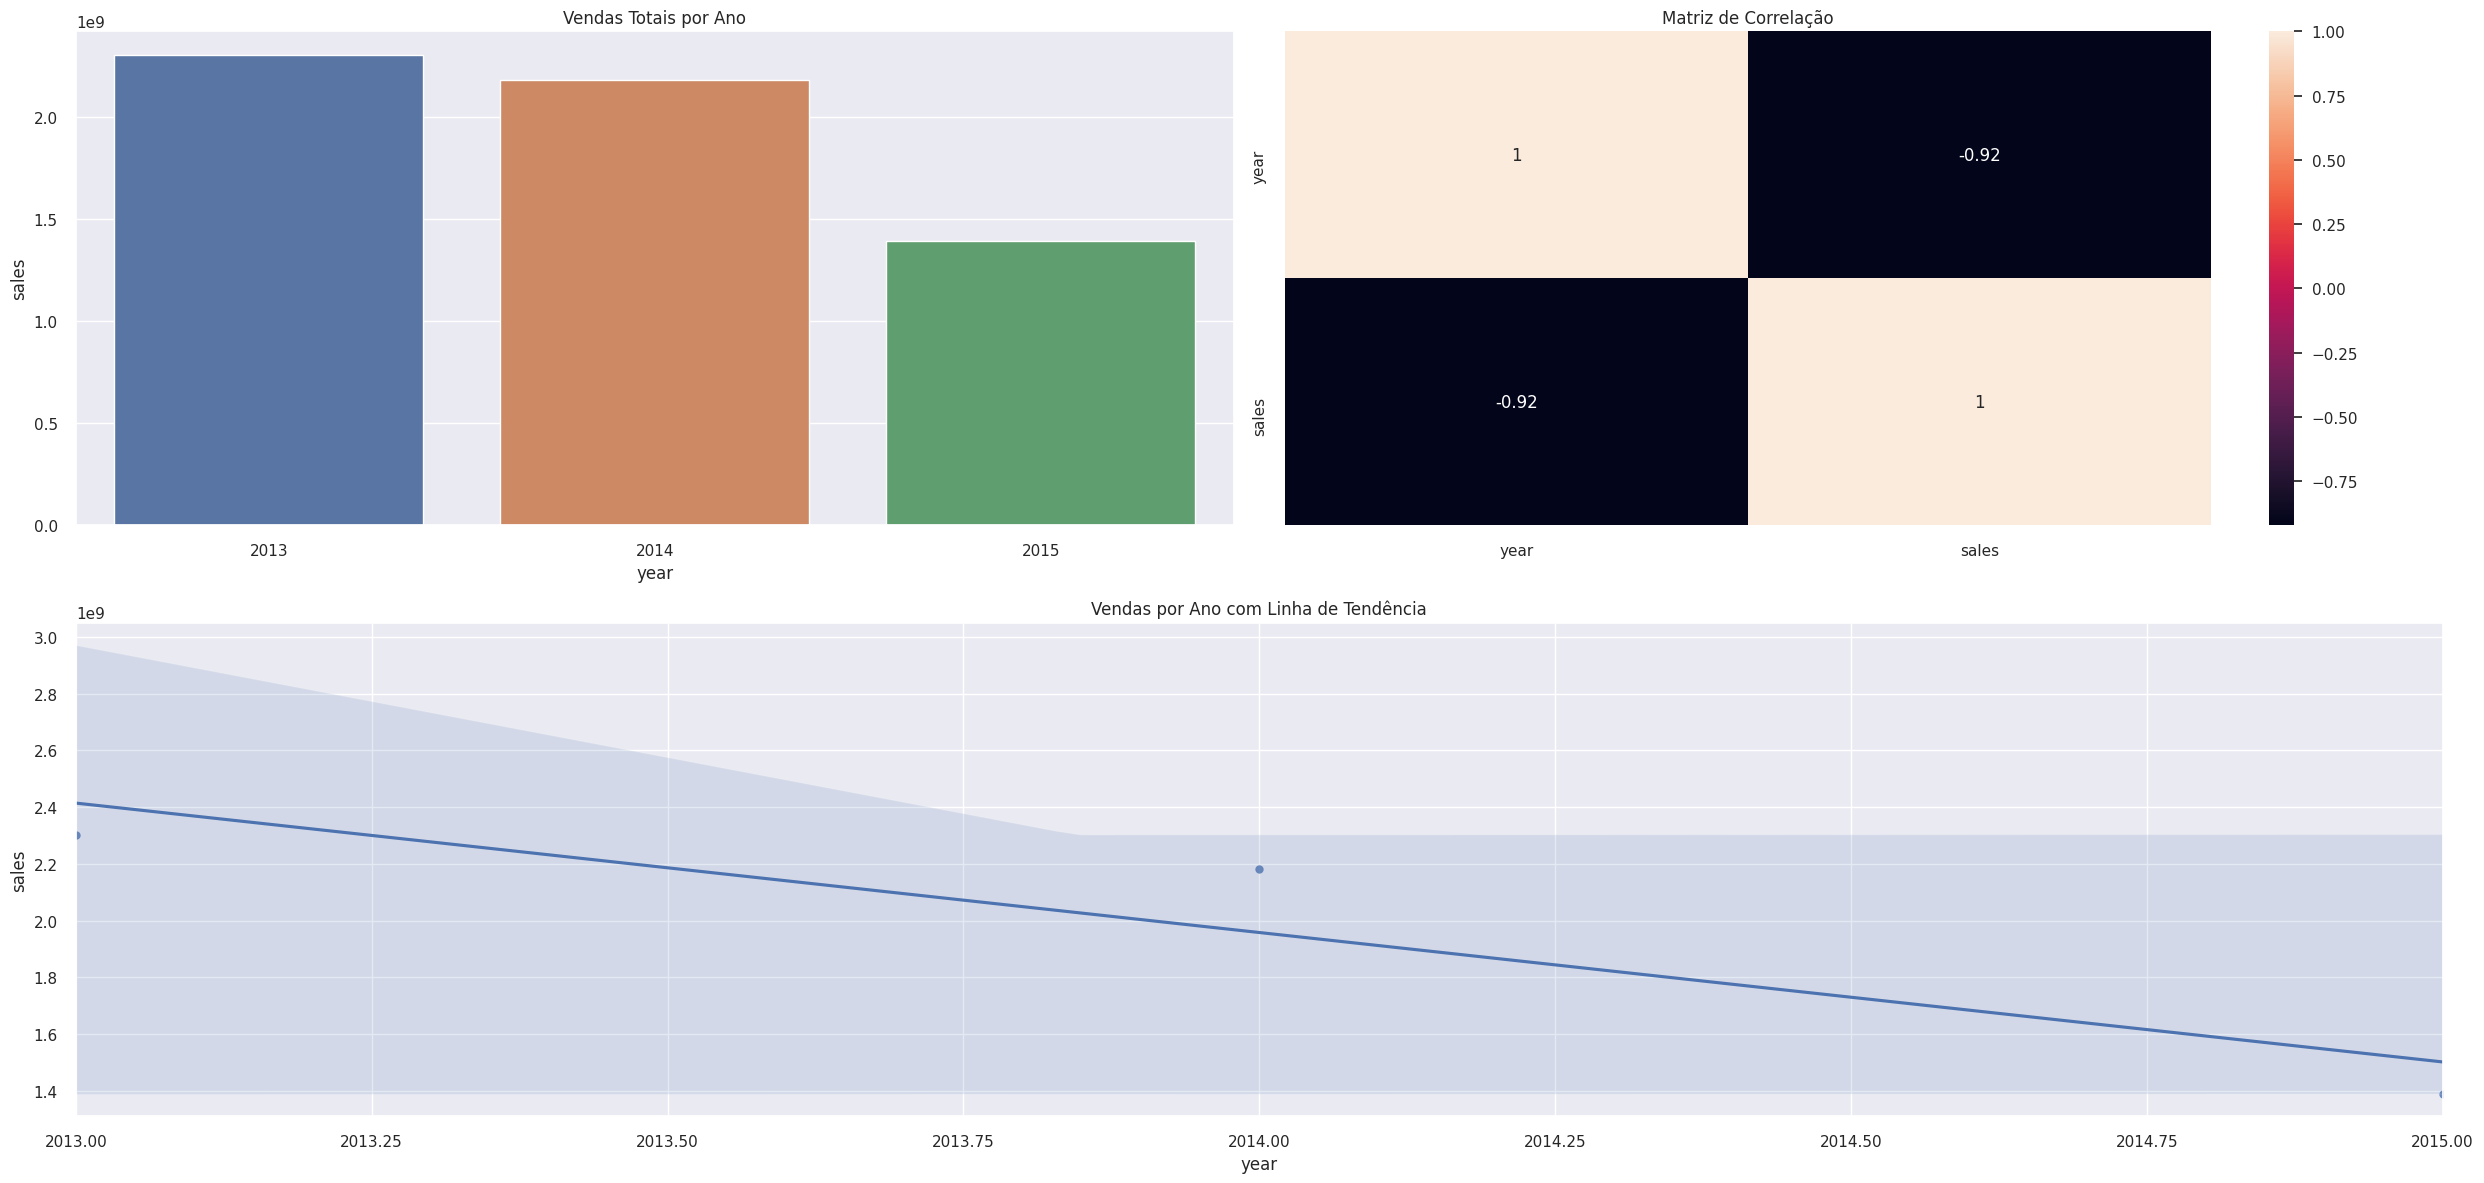

In [54]:
# Agrupa os dados por ano e soma as vendas
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Primeiro subplot: Gráfico de barras de vendas por ano
plt.subplot(221)
sns.barplot(x='year', y='sales', data=aux1)
plt.title('Vendas Totais por Ano')

# Segundo subplot: Gráfico de dispersão com linha de tendência de vendas por ano
plt.subplot(212)
sns.regplot(x='year', y='sales', data=aux1)
plt.title('Vendas por Ano com Linha de Tendência') 

# Terceiro subplot: Mapa de calor da correlação entre variáveis
plt.subplot(222)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.title('Matriz de Correlação')

plt.tight_layout()

### `H9`.Lojas deveriam vender mais no segundo semestre do ano.

##### **`FALSA`** Lojas vendem menos no segundo semestre do ano.

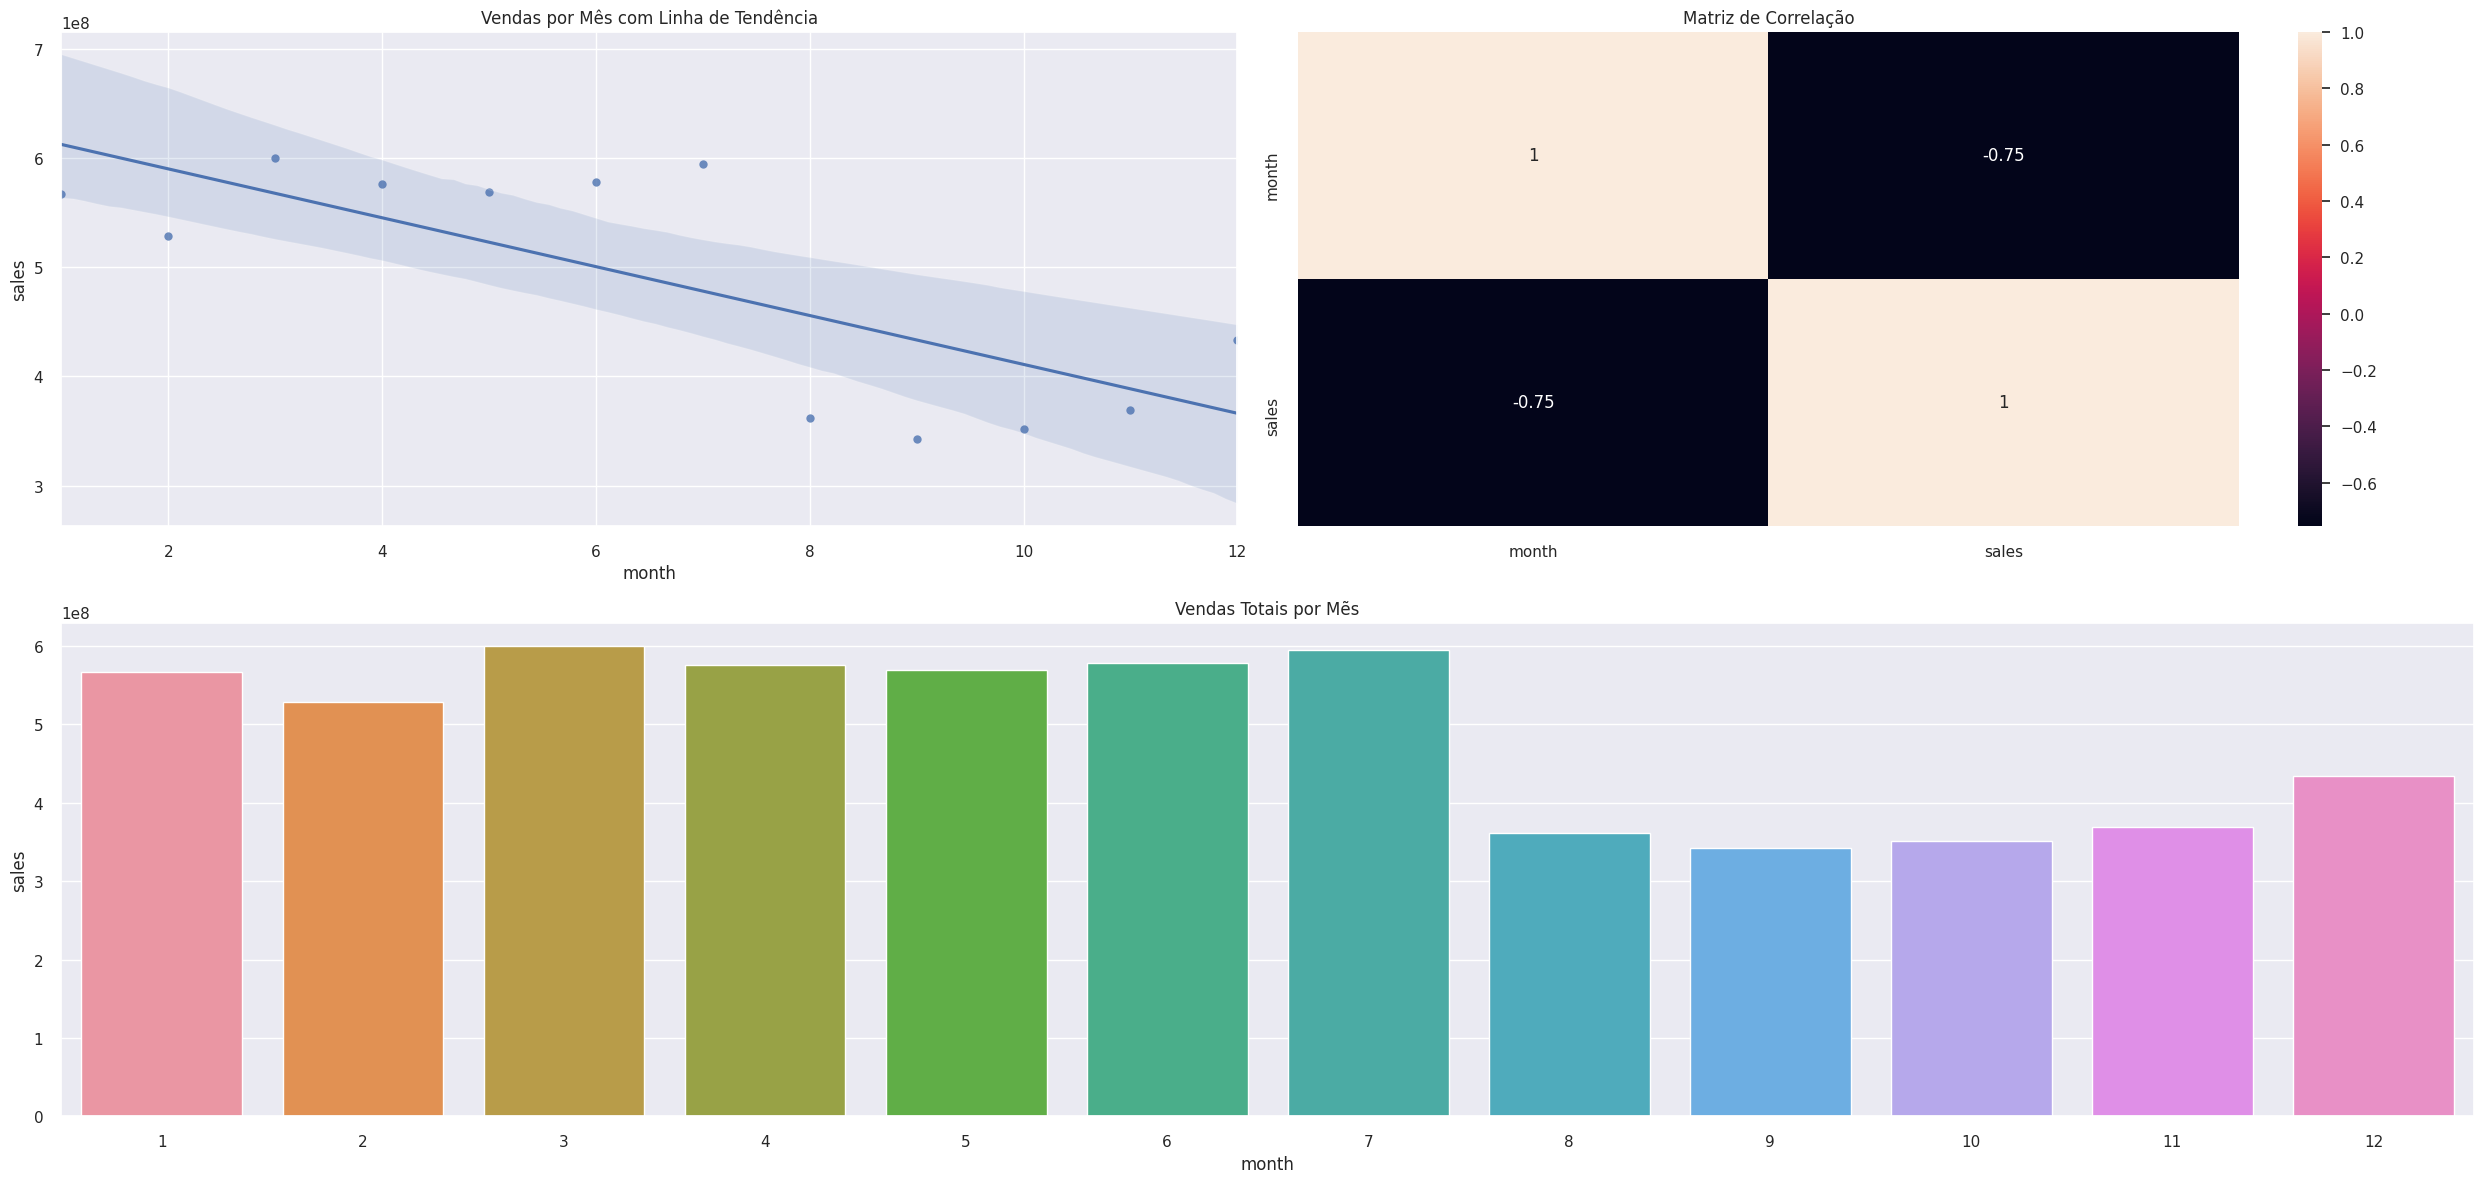

In [55]:
# Agrupa os dados por meses e soma as vendas
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Primeiro subplot: Gráfico de barras de vendas por Mês
plt.subplot(212)
sns.barplot(x='month', y='sales', data=aux1)
plt.title('Vendas Totais por Mẽs')

# Segundo subplot: Gráfico de dispersão com linha de tendência de vendas por Mês
plt.subplot(221)
sns.regplot(x='month', y='sales', data=aux1)
plt.title('Vendas por Mês com Linha de Tendência') 

# Terceiro subplot: Mapa de calor da correlação entre variáveis
plt.subplot(222)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.title('Matriz de Correlação')

plt.tight_layout()


### `H10`.Lojas deveriam vender mais depois do dia 10 de cada mês.

##### **`VERDADEIRA`** Lojas vendem mais depois do dia 10 de cada mês.

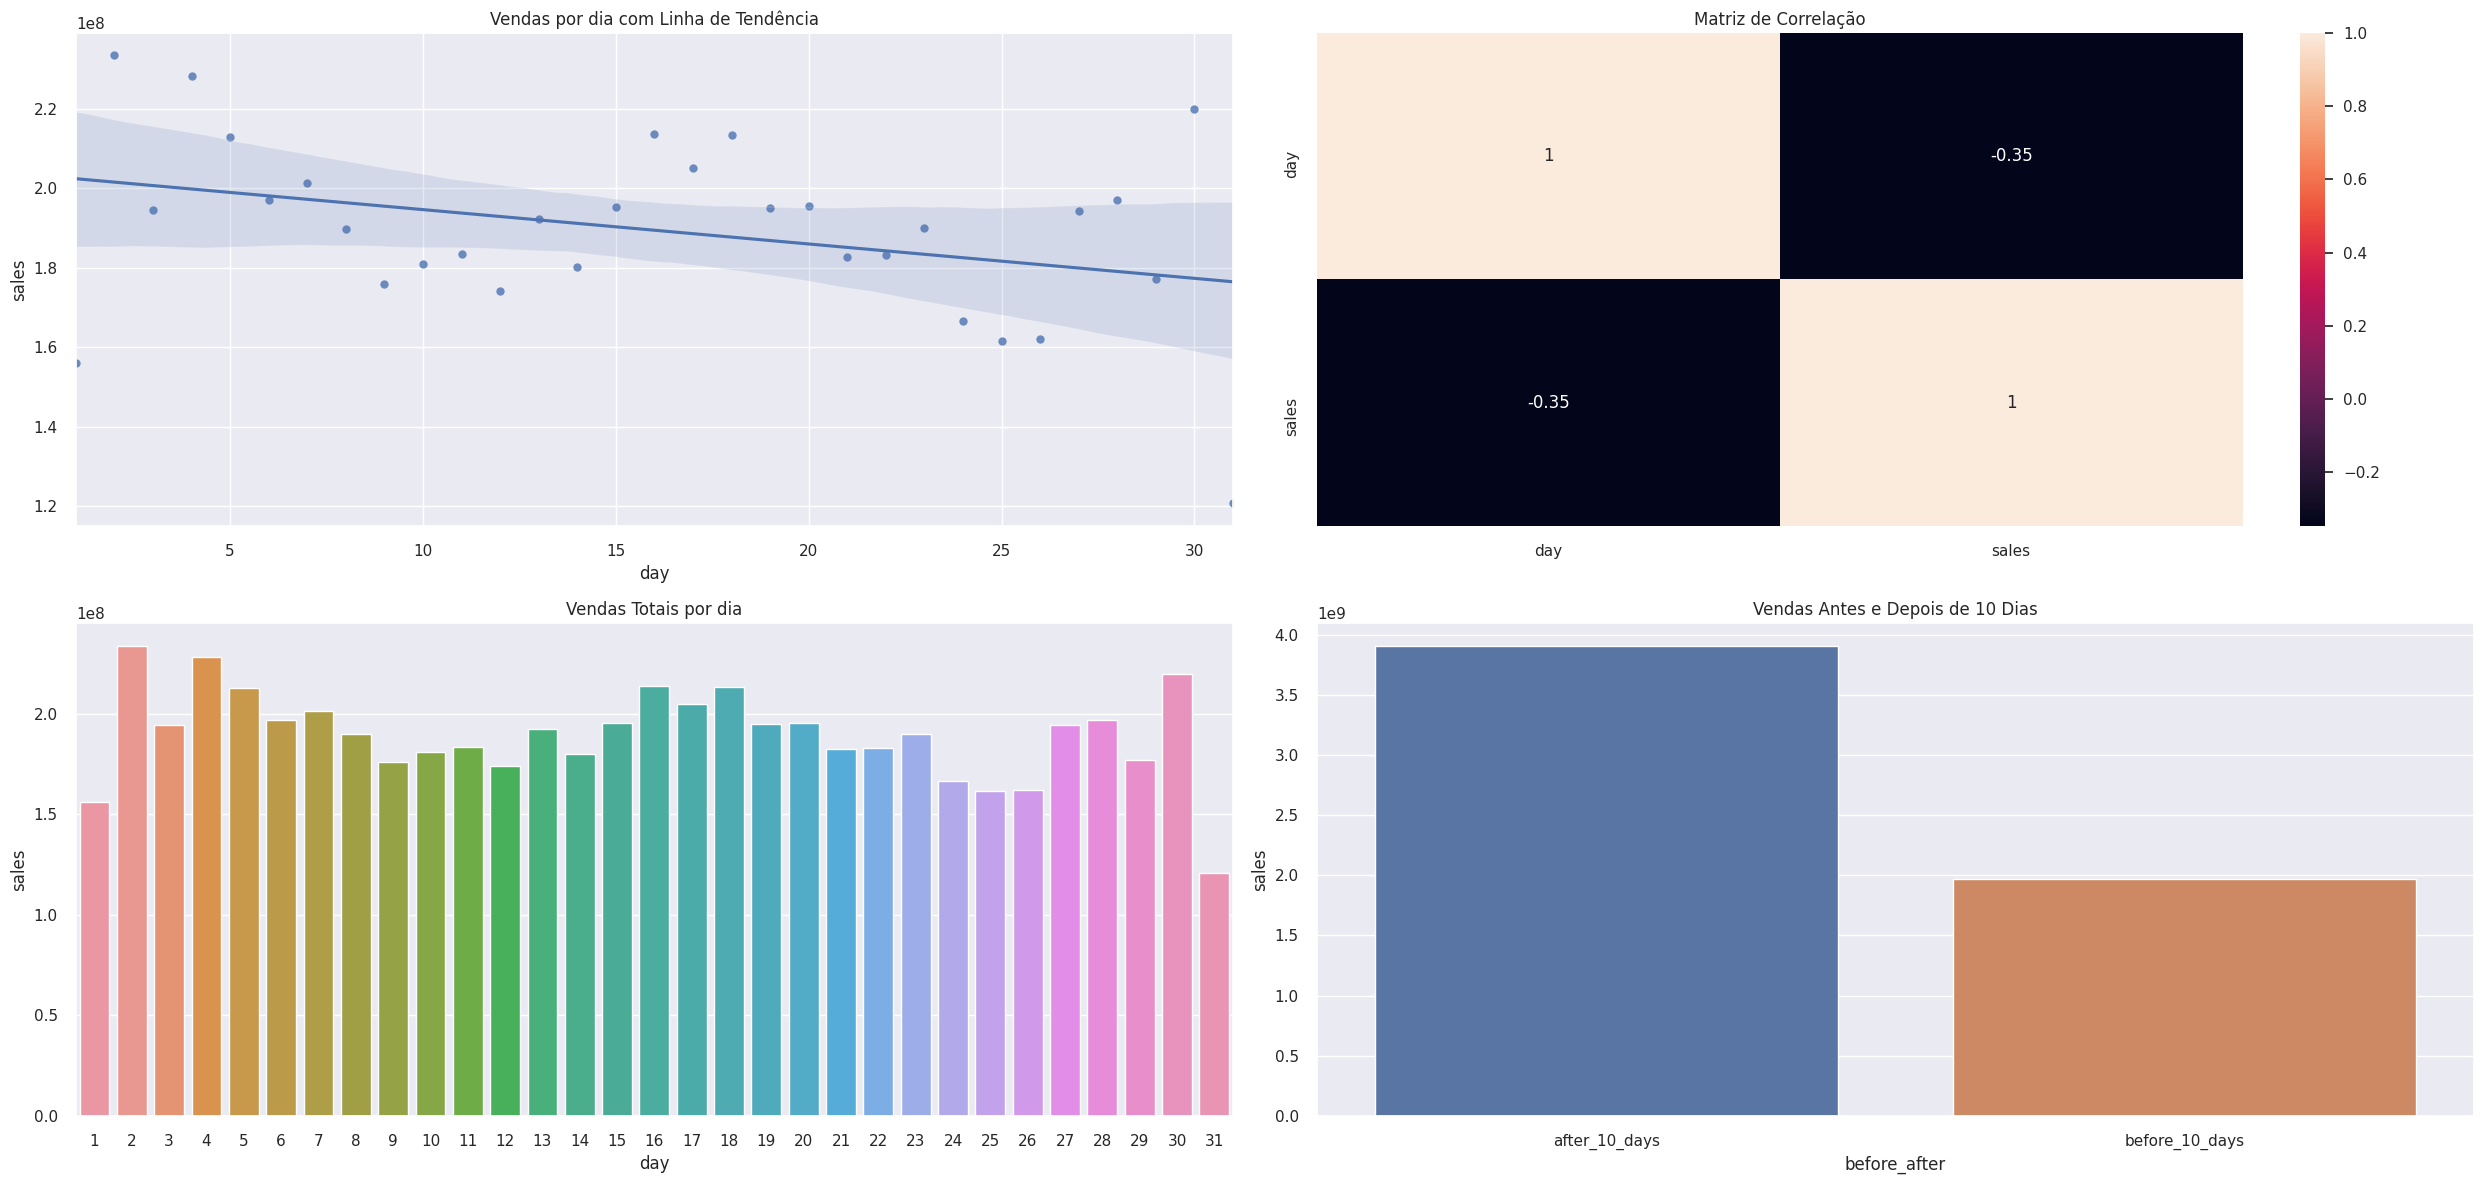

In [56]:
# Agrupa os dados por dia e soma as vendas
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Primeiro subplot: Gráfico de barras de vendas por dia
plt.subplot(223)
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Vendas Totais por dia')

# Segundo subplot: Gráfico de dispersão com linha de tendência de vendas por dia
plt.subplot(221)
sns.regplot(x='day', y='sales', data=aux1)
plt.title('Vendas por dia com Linha de Tendência') 

# Terceiro subplot: Mapa de calor da correlação entre variáveis
plt.subplot(222)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.title('Matriz de Correlação')

# Cria uma nova coluna para categorizar os dias em 'antes' e 'depois' de 10 dias
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Quarto subplot: Gráfico de barras de vendas antes e depois de 10 dia
plt.subplot(224)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.title('Vendas Antes e Depois de 10 Dias')

plt.tight_layout()

### `H11`.Lojas deveriam vender menos aos finais de semana.

##### **`VERDADEIRA`** Lojas vendem menos nos finais de semana.

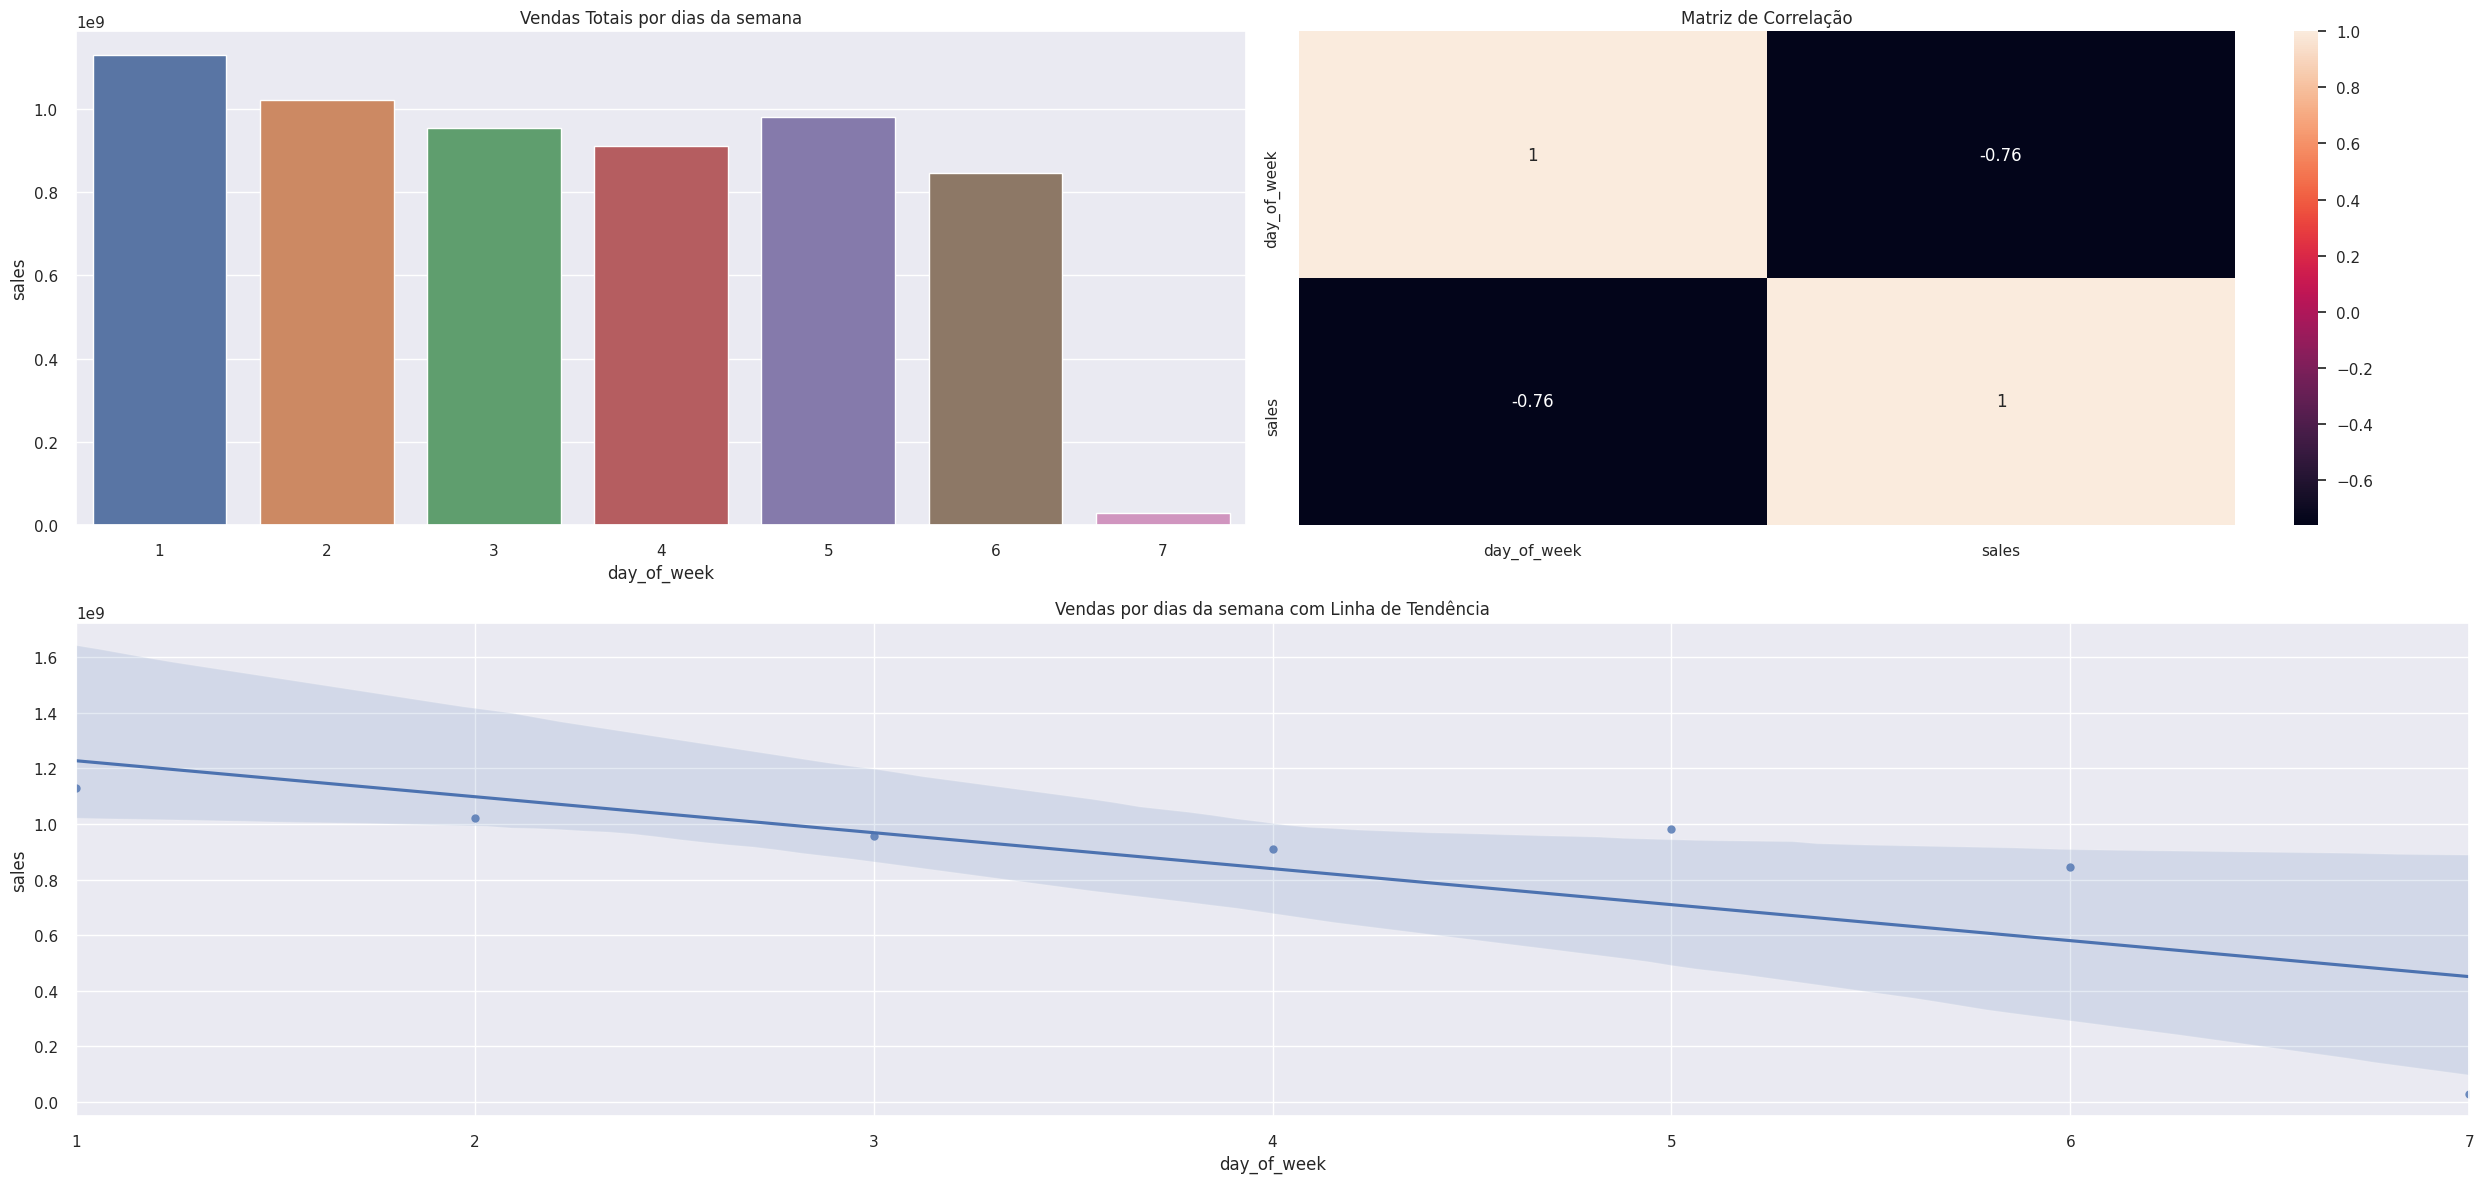

In [57]:
# Agrupa os dados por dias da semana e soma as vendas
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Primeiro subplot: Gráfico de barras de vendas por dias da semana
plt.subplot(221)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.title('Vendas Totais por dias da semana')

# Segundo subplot: Gráfico de dispersão com linha de tendência de vendas por dias da semana
plt.subplot(212)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.title('Vendas por dias da semana com Linha de Tendência') 

# Terceiro subplot: Mapa de calor da correlação entre variáveis
plt.subplot(222)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.title('Matriz de Correlação')

plt.tight_layout()

### `H12`.Lojas deveriam vender menos durante os feriados escolares.

##### **`VERDADEIRA`** Lojas vendem menos durante os feriados escolares, exeto nos meses de Julho e Agosto.

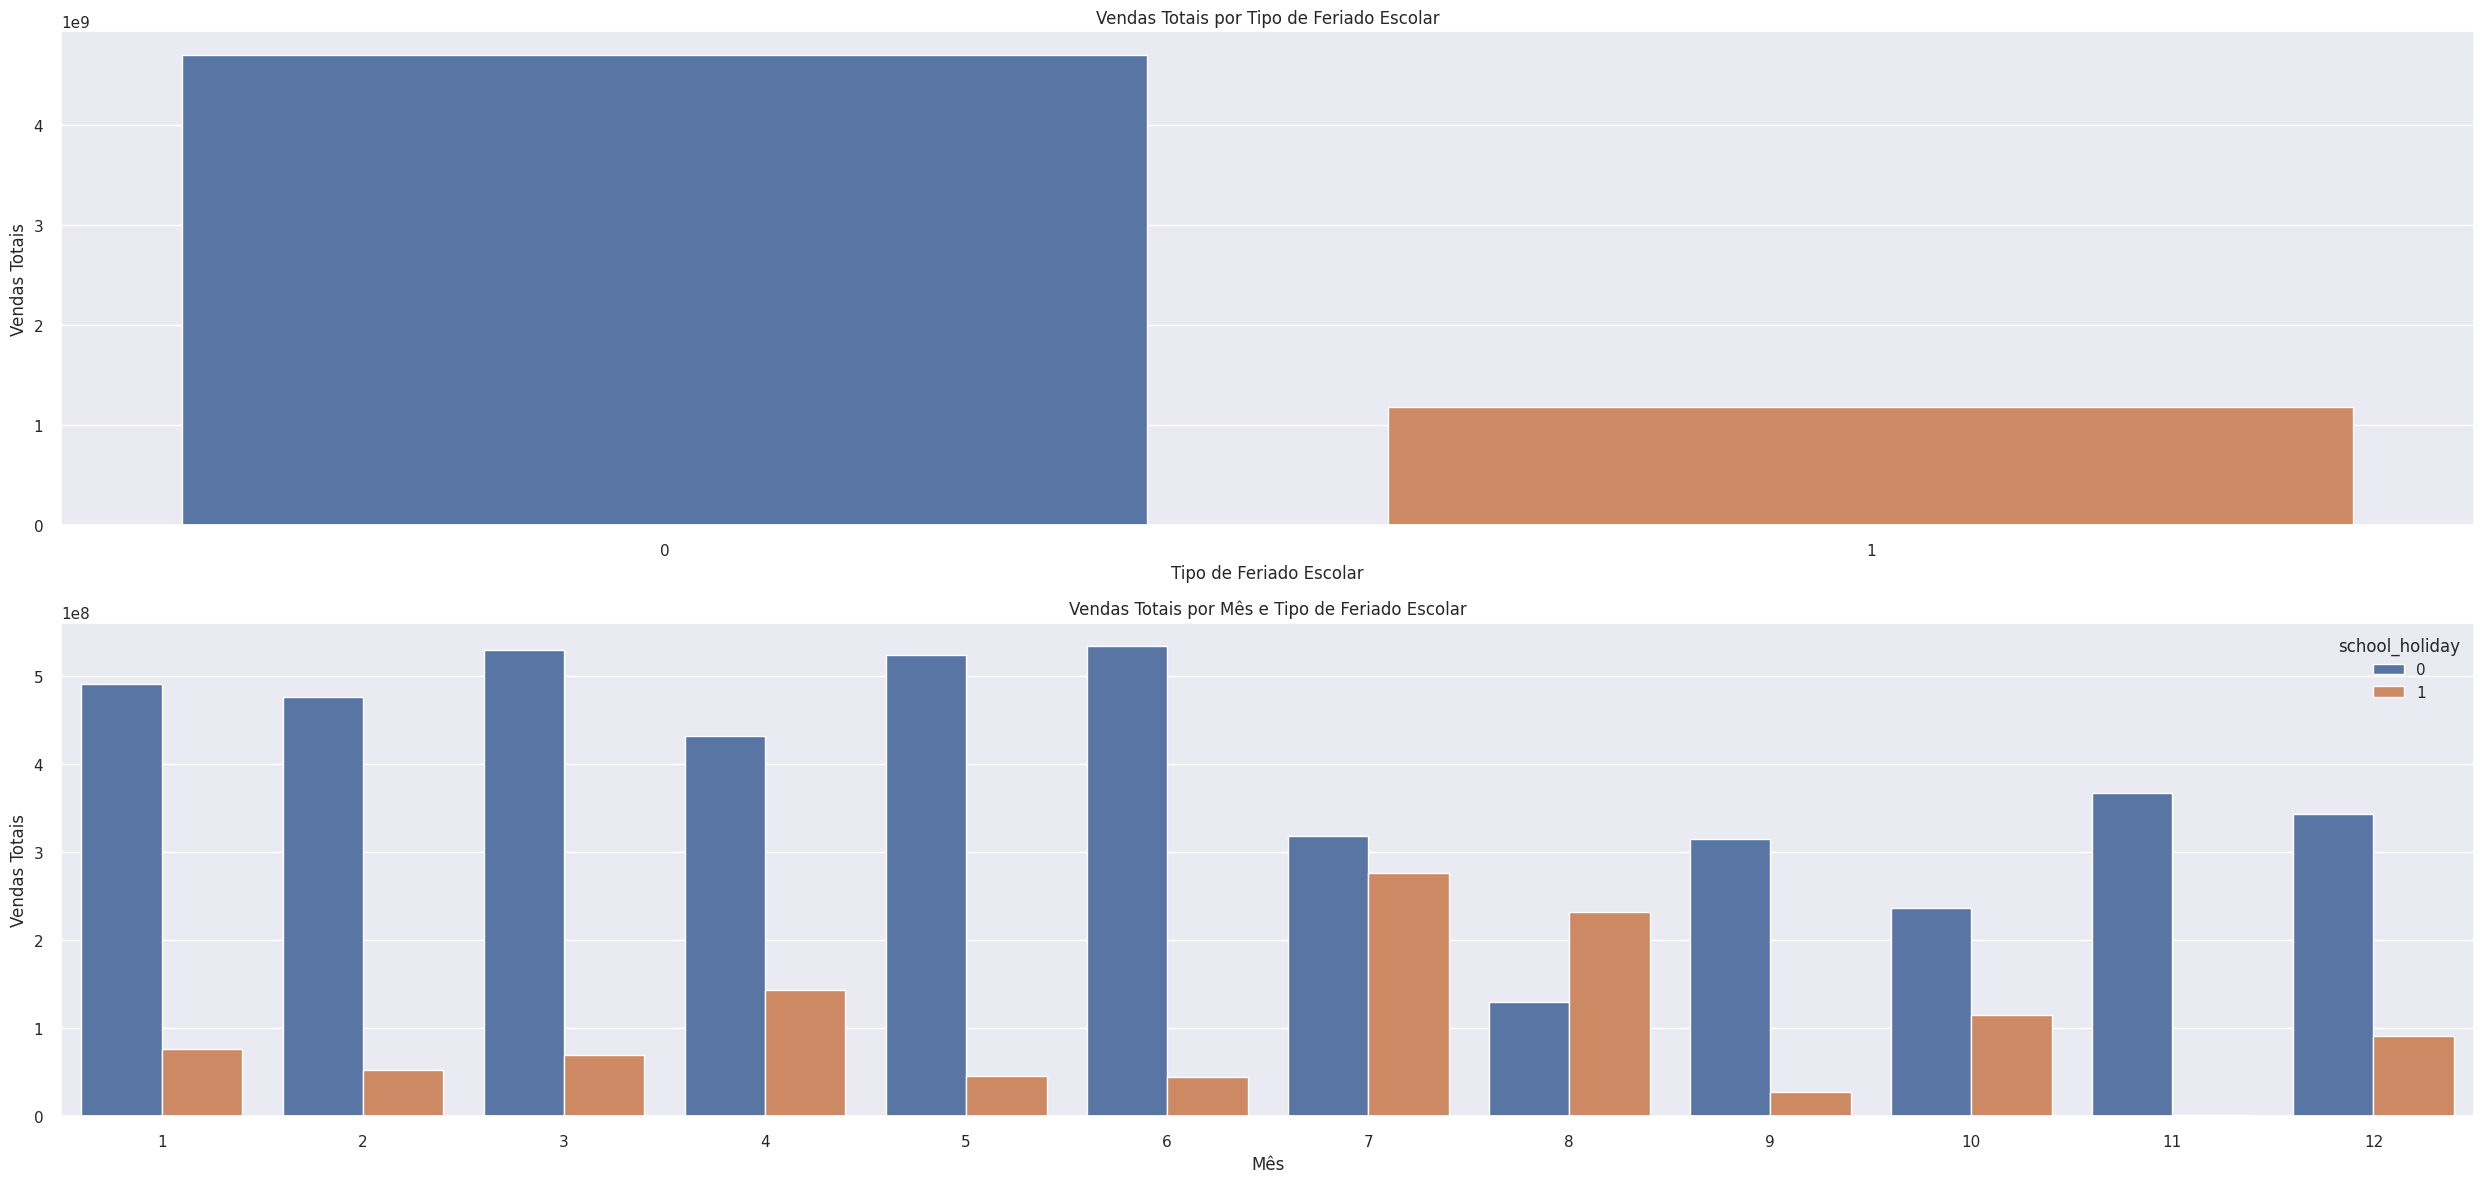

In [58]:
# Agrupa os dados por tipo de feriado escolar e soma as vendas
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()


# Primeiro subplot: Gráfico de barras de vendas por tipo de feriado escolar
plt.subplot(211)
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title('Vendas Totais por Tipo de Feriado Escolar')
plt.xlabel('Tipo de Feriado Escolar')  # Adiciona rótulo ao eixo x
plt.ylabel('Vendas Totais')  # Adiciona rótulo ao eixo y

# Agrupa os dados por mês e tipo de feriado escolar e soma as vendas
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Segundo subplot: Gráfico de barras de vendas por mês e tipo de feriado escolar
plt.subplot(212)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title('Vendas Totais por Mês e Tipo de Feriado Escolar') 
plt.xlabel('Mês')  # Adiciona rótulo ao eixo x
plt.ylabel('Vendas Totais')  # Adiciona rótulo ao eixo y

plt.tight_layout()

### `Resumo das Hipóteses`

In [59]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa']
]

In [60]:
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## Análise `Multivariada`

### Atributos `Numéricos`

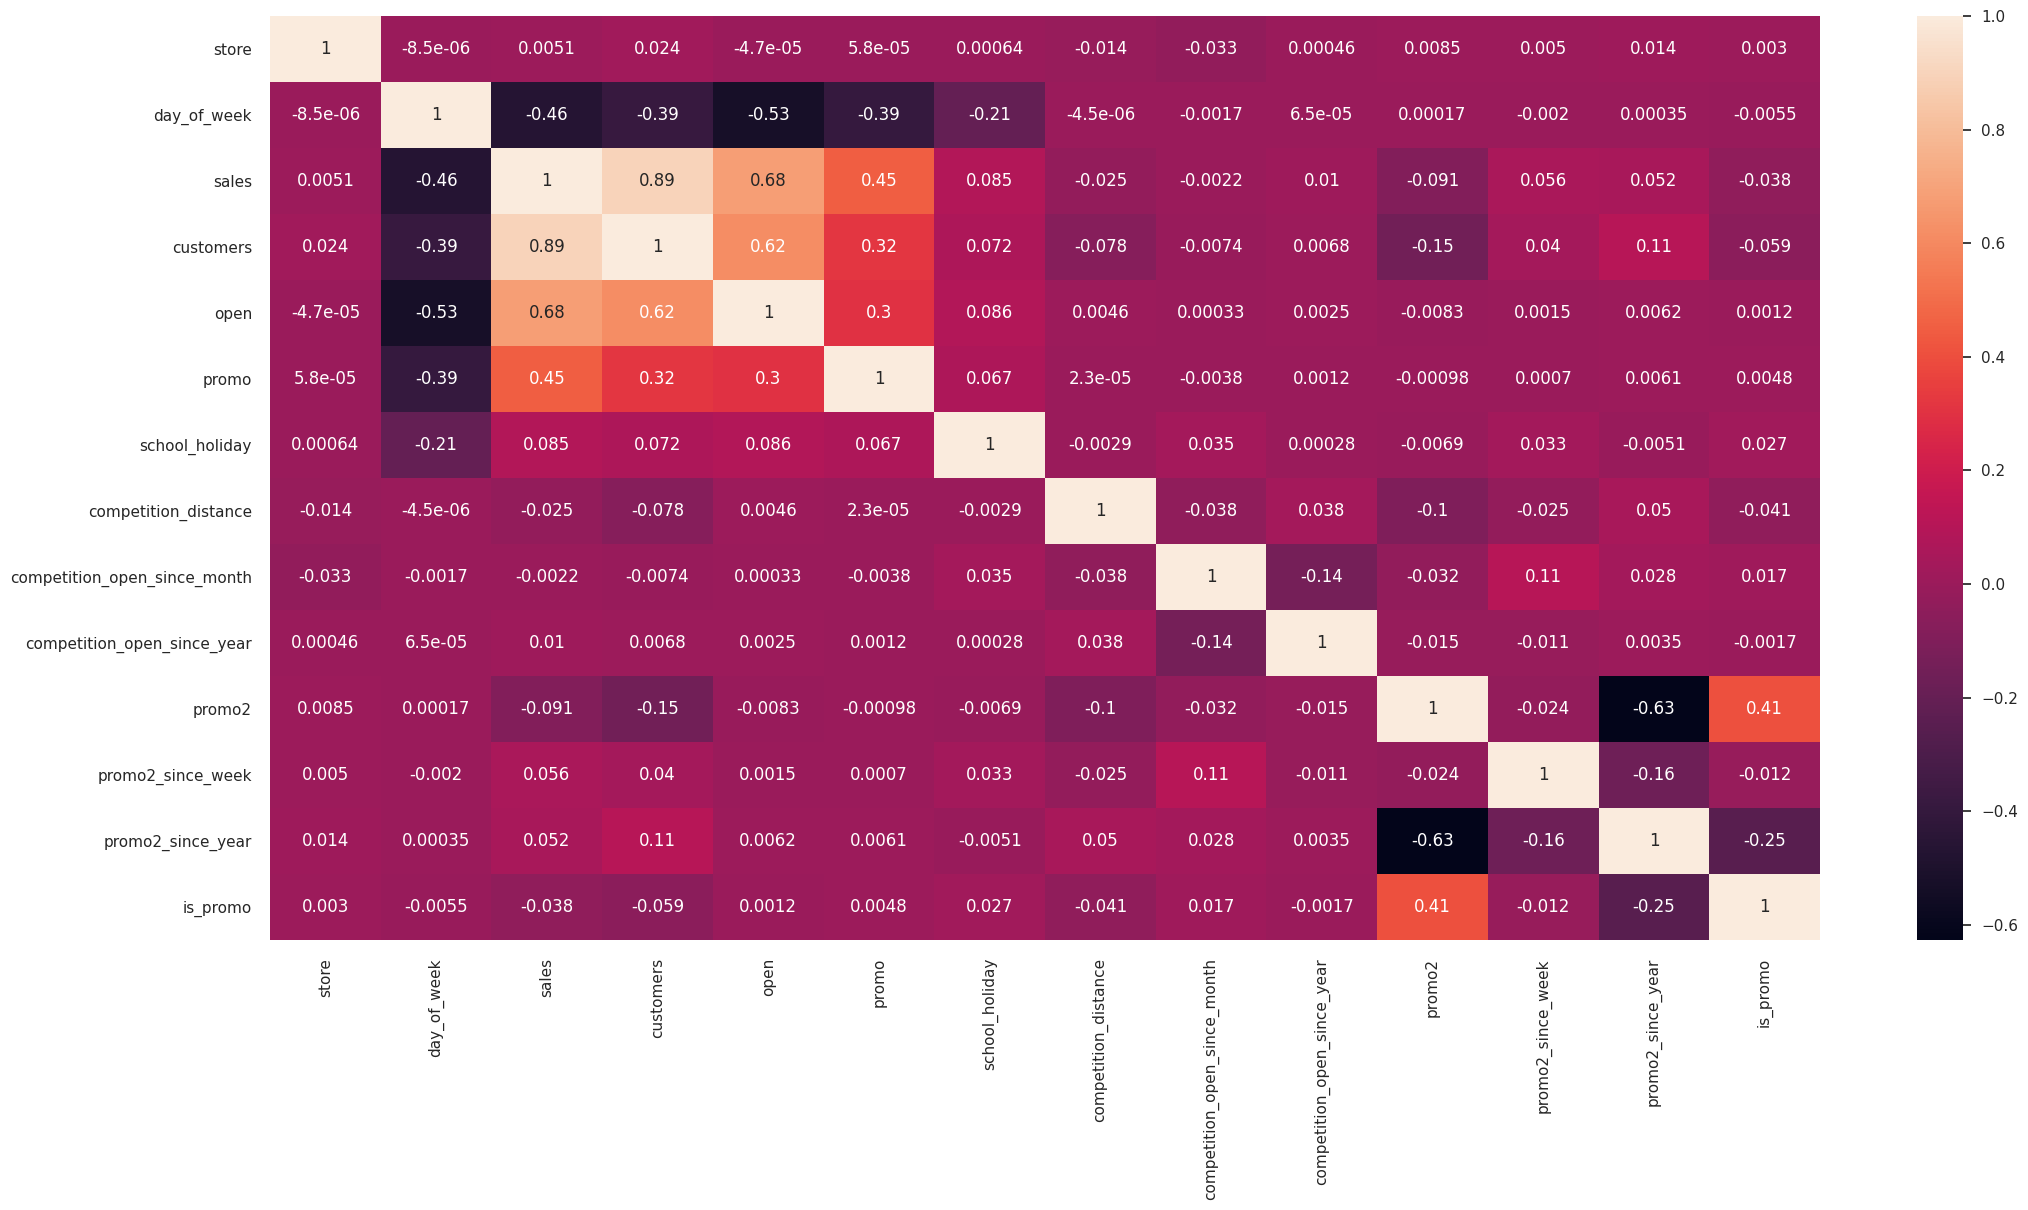

In [61]:
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot=True);

In [62]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

In [63]:
# Reordenar as colunas de 'num_attributes'
order_cols = ['sales',
              'store', 
              'day_of_week', 
              'customers', 
              'open', 
              'promo',
              'school_holiday', 
              'competition_distance',
              'competition_open_since_month', 
              'competition_open_since_year', 
              'promo2',
              'promo2_since_week', 
              'promo2_since_year', 
              'is_promo']

num_attributes.columns = order_cols

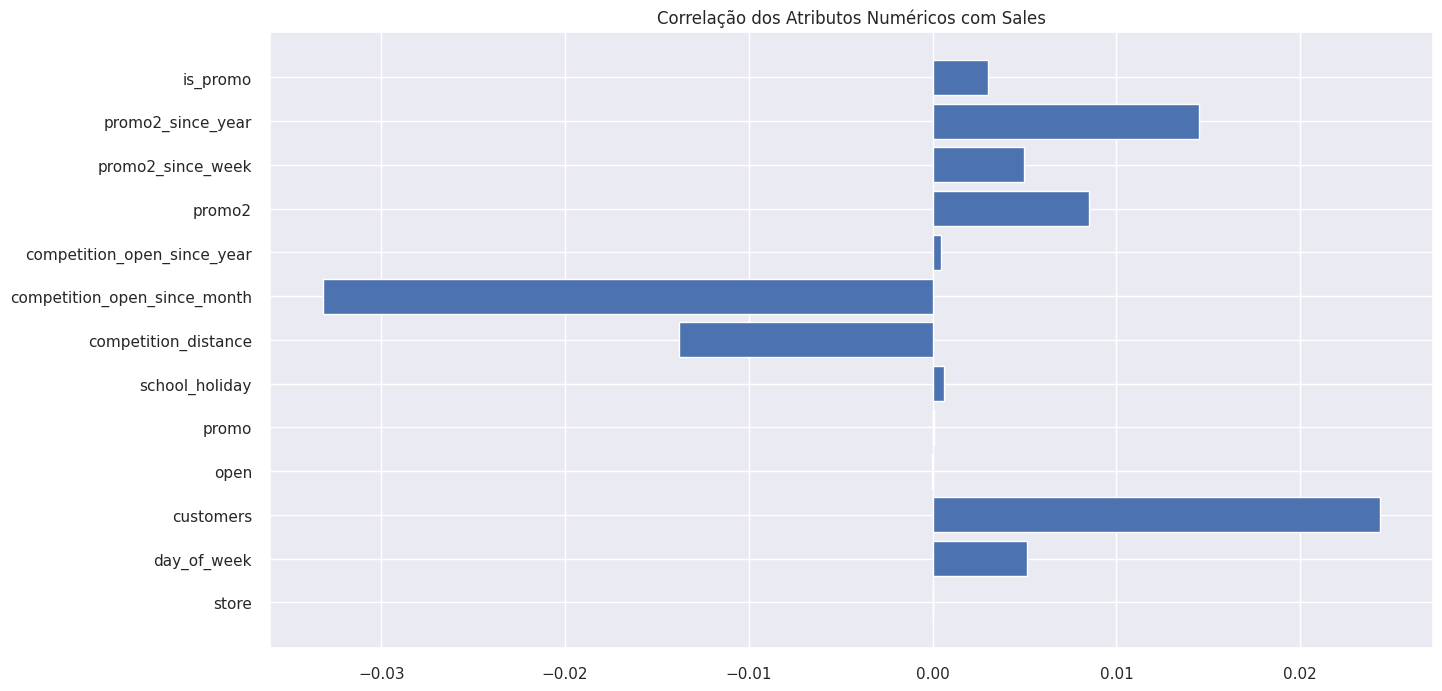

In [64]:
# Correlação de todas variáveis númericas com a varável'sales', uilizando a biblioteca yellowbrick

plt.figure(figsize=(15, 8))

# Inicialize o FeatureCorrelation com os labels (nomes das colunas, exceto a primeira coluna 'sales')
yellow_corr = FeatureCorrelation(labels=num_attributes.columns[1:])

# Ajuste o FeatureCorrelation com os dados
# A primeira coluna 'sales' é a variável alvo (y), e as outras colunas são as características (X)
# 'iloc[:, 1:]' seleciona todas as colunas exceto a primeira
# 'iloc[:, 0]' seleciona a primeira coluna como a variável alvo
yellow_corr.fit(num_attributes.iloc[:, 1:].values, num_attributes.iloc[:, 0].values)

plt.title( 'Correlação dos Atributos Numéricos com Sales')
plt.show()

### Atributos `Categóricos`

In [65]:
# Filtrando as variáveis categóricas
a = df4.select_dtypes(include='object')

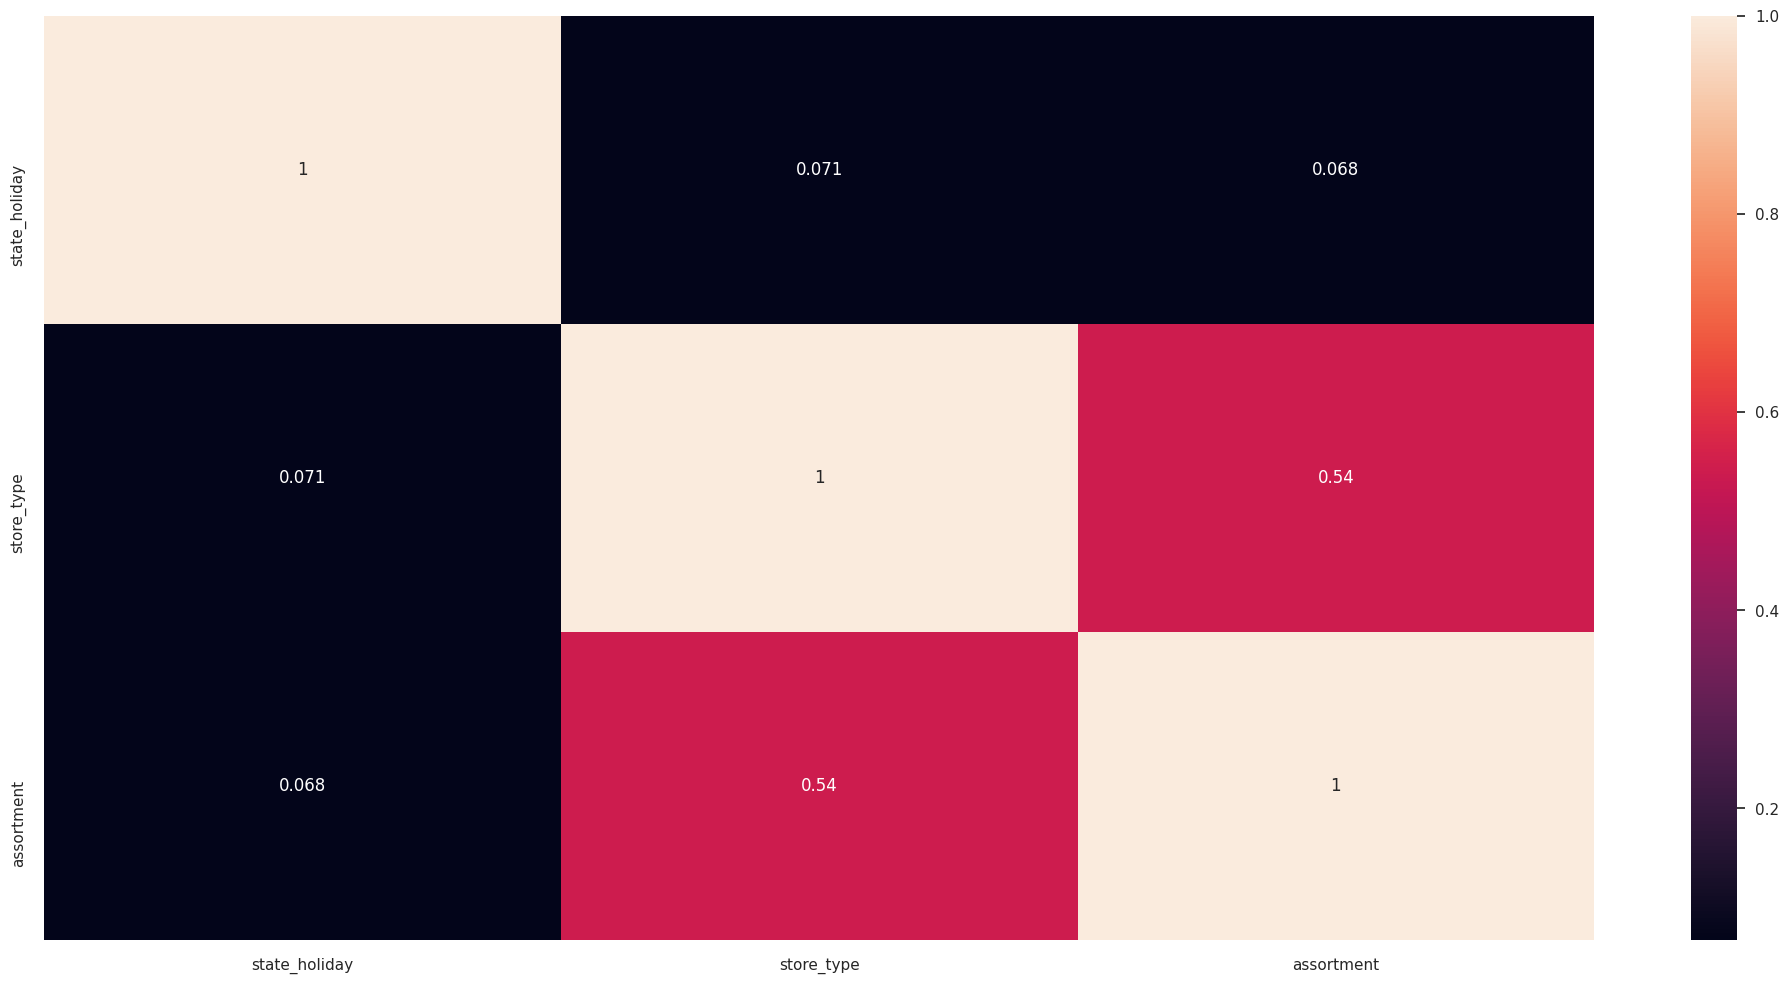

In [66]:
# Calculando o V de Cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Criando o DataFrame
d = pd.DataFrame({  'state_holiday': [a1, a2, a3],
                    'store_type':    [a4, a5, a6],
                    'assortment':    [a7, a8, a9]  })
# Ajustando o índice para refletir as colunas, criando uma matriz simétrica
d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

In [67]:
info['state_holiday'],info['store_type'],info['assortment']

("Indica um feriado estadual. ('public_holiday', 'easter_holiday', 'christmas')",
 'Indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)',
 'Descreve um nível de sortimento: básico, extra, estendido')

| Atributos                 | Correlação | Interpretação                  |
|---------------------------|------------|------------------------------|
| state_holiday e store_type | 0.071     | Correlação muito fraca         |
| state_holiday e assortment | 0.068     | Correlação muito fraca         |
| store_type e assortment    | 0.54      | Correlação moderada           |



# `PREPARAÇÃO DOS DADOS`

In [68]:
df5 = df4.copy()

## `Anotações`

O aprendizado da maioria dos algoritmos de ML é facilitado com dados numéricos, na mesma escala.

Existem 2 tipos de dados dentro do conjunto de dados que precisam ser modificados:
1. As variáveis categóricas precisam ser convertidas para variáveis numéricas, para que os algoritmos do ML consigam usar essas variáveis para aprender.
2. Equalizar a importância das variáveis pois os algoritmos de ML tendem a dar mais importância para as variáveis com range maior, devido a isso é necessário colocar todas variáveis no mesmo range.

## <s>Normalização</s>

> Como nenhuma das variáveis numéricas possui distribuição normal, optei por não aplicar a normalização.

## Rescaling

### `Anotações`

#### Redimensionamento de Variáveis (Rescaling)
Métodos utilizados para redimensionar variáveis que não seguem uma distribuição normal.

**Min-Max Scaler:**

- Mantém a distribuição original dos dados, alterando apenas o intervalo (range) para um novo mínimo e máximo. No entanto, é sensível a outliers, que podem distorcer os resultados.

**Robust Scaler:**
- Utiliza o intervalo interquartil (IQR) para redimensionar as variáveis, tornando-o menos influenciado por outliers, ideal para dados com valores extremos.

### `Code`

In [69]:
# conferindo os tipos de dados
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

In [70]:
# Convertendo as colunas 'year', 'month', 'day', e 'week_of_year' para o tipo inteiro de 64 bits (int64).
df5[['year', 'month', 'day', 'week_of_year']] = df5[['year', 'month', 'day', 'week_of_year']].astype('int64')

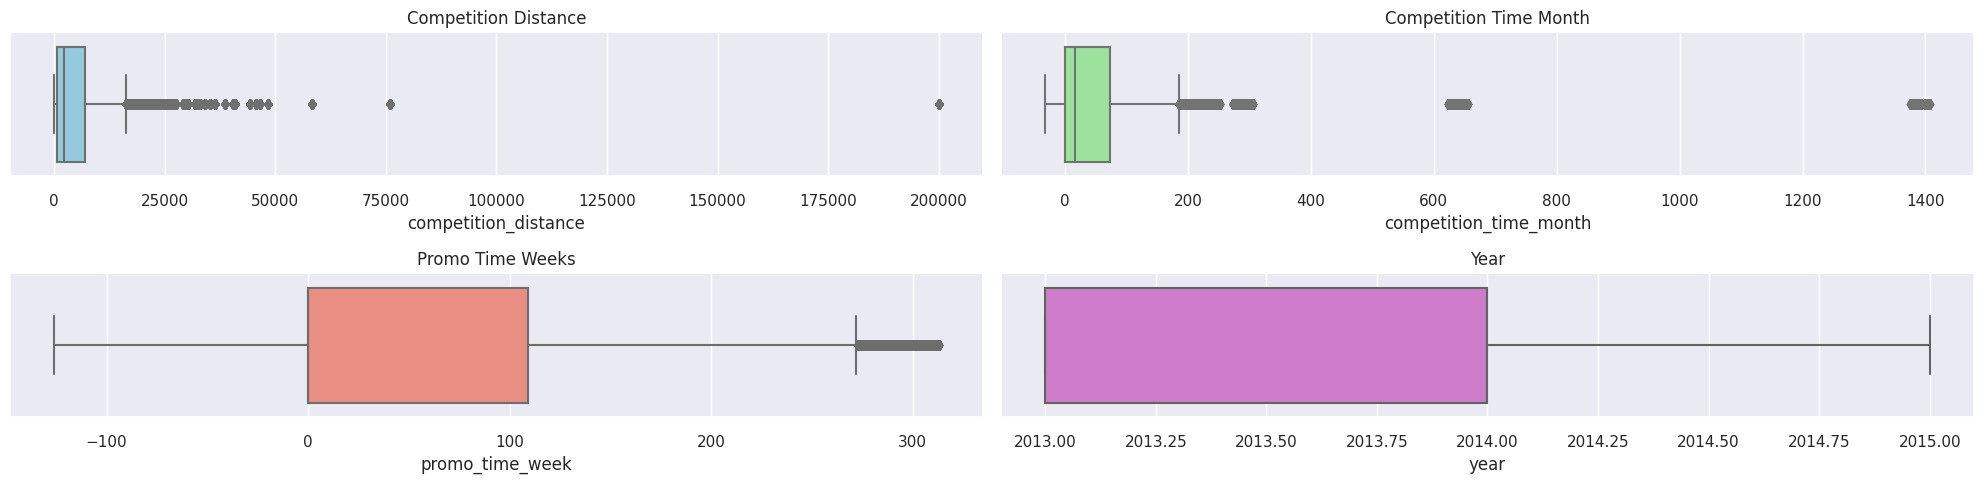

In [71]:
# Verificando Outliers

plt.figure(figsize=(20, 5))

# Primeiro subplot - competition_distance
plt.subplot(221)
sns.boxplot(df5['competition_distance'], color='skyblue')
plt.title('Competition Distance')

# Segundo subplot - competition_time_month
plt.subplot(222)
sns.boxplot(df5['competition_time_month'], color='lightgreen')
plt.title('Competition Time Month')

# Terceiro subplot - promo_time_week
plt.subplot(223)
sns.boxplot(df5['promo_time_week'], color='salmon')
plt.title('Promo Time Weeks')

# Quarto subplot - year
plt.subplot(224)
sns.boxplot(df5['year'], color='orchid')
plt.title('Year')

plt.tight_layout();

In [72]:
# Redimensionamento de Variáveis

rs = RobustScaler() 
mms = MinMaxScaler() 

# Robust Scaler
# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values ) 

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values ) 

# Min-Max Scaler
# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values ) 

# year
df5['year'] = mms.fit_transform( df5[['year']].values ) 

## Transformação

### Enconding

In [73]:
# state_holiday - One Hot Enconding
# One Hot Encoding é utilizado para converter a variável categórica 'state_holiday' em variáveis dummy.
# Isso cria novas colunas binárias (0 ou 1) para cada categoria, permitindo que o modelo trate essas categorias de forma numérica.
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] ) 

# store_type - Label Encoding
# Label Encoding é aplicado à variável 'store_type', convertendo as categorias em números inteiros.
# Isso permite que o modelo use essas categorias como valores numéricos, onde cada tipo de loja recebe um número distinto.
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
# Ordinal Encoding é utilizado para a variável 'assortment', onde as categorias possuem uma ordem natural.
# Nesse caso, as categorias 'basic', 'extra' e 'extended' são mapeadas para 1, 2 e 3, respectivamente, refletindo a ordem crescente de variedade.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### Transformação da Variável Resposta

In [74]:
# Aplicando transformação logarítmica aos valores de 'sales'
# Facilita a modelagem ao reduzir o impacto de valores extremos e melhorar a linearidade dos dados.
df5['sales'] = np.log1p(df5['sales'])

### Transformação de Natureza

In [75]:
# day
# Representação cíclica do dia usando seno e cosseno para capturar a natureza periódica dos dias do mês.
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x *  ( 2. * np.pi/30 )) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x *  ( 2. * np.pi/30 )) )

# month
# Transformação cíclica para o mês, utilizando seno e cosseno para representar a periodicidade dos meses do ano.
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x *  ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x *  ( 2. * np.pi/12 )) )

# day of week
# Codificação cíclica do dia da semana, aplicando seno e cosseno para modelar a repetição semanal.
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x *  ( 2. * np.pi/7 )) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x *  ( 2. * np.pi/7 )) )

# week of year
# Aplicação de seno e cosseno para capturar a periodicidade semanal ao longo do ano.
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x *  ( 2. * np.pi/52 )) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x *  ( 2. * np.pi/52 )) )

In [76]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984


# `SELEÇÃO DE VARIÁVEIS`

In [77]:
df6 = df5.copy()

### Dividindo o dataframe em conjuntos de dados de treinamento e teste

In [78]:
# Dropando variáveis que derivaram as variáveis que serão utilizadas no modelo
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [79]:
# Data minima para cada loja
df6[['store', 'date']].groupby('store').min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

In [80]:
# Data maxima para cada loja
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [81]:
# data que começa as 6 semanas até o final
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - dt.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [82]:
# Definindo o conjunto de treinamento
# Seleciona os dados onde a data é anterior a '2015-06-19'
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales'] # variável resposta para o conjunto de treinamento

# Definindo o conjunto de teste
# Seleciona os dados onde a data é igual ou posterior a '2015-06-19'
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales'] # variável resposta para o conjunto de teste

# Exibindo a data mínima e máxima do conjunto de treinamento
print('Training Min Date: {}'.format( X_train['date'].min() ) )
print('Training Max Date: {}'.format( X_train['date'].max() ) )

# Exibindo a data mínima e máxima do conjunto de teste
print('\nTest Min Date: {}'.format( X_test['date'].min() ) )
print('Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### Seleção de variáveis com `Boruta`

In [83]:
## training and test datasets for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define randomForestReegressor 
#rf = RandomForestRegressor(n_jobs=-1)
#
## define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### Melhores variáveis do Boruta

In [84]:
## Lista booleana indicando quais variáveis foram consideradas importantes pelo Boruta
#cols_selected = boruta.support_.tolist()
#
## Removendo as variáveis 'date' e 'sales' de X_train, pois elas não serão consideradas na seleção de variáveis
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#
## Obtendo os nomes das variáveis que foram selecionadas pelo Boruta como importantes
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()
#
## Obtendo os nomes das variáveis que não foram selecionadas pelo Boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### Seleção Manual de Variáveis

In [85]:
# Comparando as Hipoteses de alta Relevância com as variáveis seleciondas pelo Boruta
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


In [86]:
# Após comparar as variáveis selecionadas pelo Boruta com as hipóteses, foram adicionadas as variáveis 'month_sin' e 'week_of_year_sin' 
# Apesar da H9 ter mostrado alta relevância, optei por não adicionar a variável 'year' neste ciclo do processo CRISP-DM.
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_sin',
                        'day_cos',
                        'month_sin',
                        'month_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos' 
                        ]

# Variáveis reintegradas
feat_to_add = ['date', 'sales']

# Variáveis finais selecionadas
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [87]:
# Variáveis selecionadas
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# `MACHINE LEARNING MODELLING`

In [88]:
# Selecionando as variáveis filtradas pelo Boruta para o conjunto de treino
x_train = X_train[cols_selected_boruta]
# # Selecionando as variáveis filtradas pelo Boruta para o conjunto de teste
x_test = X_test[cols_selected_boruta]

# Preparação dos dados de séries temporais com as variáveis selecionadas pelo Boruta para o conjunto de treino completo
x_training = X_train[cols_selected_boruta_full] 

## Average Model

In [89]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

## Linear Regression Model

In [90]:
# model
lr= LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

### Linear Regression Model - Cross Validation

In [91]:
# Realizando validação cruzada com 5 folds utilizando o modelo de Regressão Linear
# A função 'cross_validation' aplica o modelo 'lr' (Linear Regression) nos dados de treino (x_training)
# O parâmetro 'verbose=False' indica que não haverá saída detalhada do processo de validação
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37


## Linear Regression Regularized Model - Lasso

In [92]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451739


### Lasso - Cross Validation

In [93]:
# Realizando validação cruzada com 5 folds utilizando o modelo Lasso (uma variante da Regressão Linear com regularização L1)
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 ± 341.5,0.29 ± 0.01,3057.75 ± 504.26


## Random Forest Regressor

In [94]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))

### Random Forest Regressor - Cross Validation

In [95]:
# Realizando validação cruzada com 5 folds utilizando o modelo Random Forest Regressor
# O parâmetro 'verbose=True' indica que será exibido o progresso detalhado durante o processo de validação
rf_result_cv = cross_validation(x_training, 5, 'Rabdom Forest Regressor', rf, verbose=True)
rf_result_cv


Número do KFold:  5
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2014-11-19 00:00:00
Data de início da validação KFold:  2014-11-20 00:00:00
Data de fim da validação KFold:  2015-01-01 00:00:00

Número do KFold:  4
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2014-12-31 00:00:00
Data de início da validação KFold:  2015-01-01 00:00:00
Data de fim da validação KFold:  2015-02-12 00:00:00

Número do KFold:  3
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2015-02-11 00:00:00
Data de início da validação KFold:  2015-02-12 00:00:00
Data de fim da validação KFold:  2015-03-26 00:00:00

Número do KFold:  2
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2015-03-25 00:00:00
Data de início da validação KFold:  2015-03-26 00:00:00
Data de fim da validação KFold:  2015-05-07 00:00:00

Número do KFold:  1
Data de início do treino KFold:  2013-01-01 00:

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Rabdom Forest Regressor,837.85 ± 218.37,0.12 ± 0.02,1256.99 ± 318.69


## XGBoost Regressor

In [96]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

### XGBoost Regressor - Cross Validation

In [97]:
# Realizando validação cruzada com 5 folds utilizando o modelo XGBoost Regressor
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


Número do KFold:  5
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2014-11-19 00:00:00
Data de início da validação KFold:  2014-11-20 00:00:00
Data de fim da validação KFold:  2015-01-01 00:00:00

Número do KFold:  4
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2014-12-31 00:00:00
Data de início da validação KFold:  2015-01-01 00:00:00
Data de fim da validação KFold:  2015-02-12 00:00:00

Número do KFold:  3
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2015-02-11 00:00:00
Data de início da validação KFold:  2015-02-12 00:00:00
Data de fim da validação KFold:  2015-03-26 00:00:00

Número do KFold:  2
Data de início do treino KFold:  2013-01-01 00:00:00
Data de fim do treino KFold:  2015-03-25 00:00:00
Data de início da validação KFold:  2015-03-26 00:00:00
Data de fim da validação KFold:  2015-05-07 00:00:00

Número do KFold:  1
Data de início do treino KFold:  2013-01-01 00:

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,989.53 ± 173.45,0.14 ± 0.02,1432.47 ± 246.57


## `Models Performance`

### Single Performance

In [98]:
# resultados combinados
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_results.sort_values('RMSE').reset_index(drop=True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.814042,0.099833,1009.066841
1,XGBoost Regressor,810.213588,0.117724,1195.959028
2,Average Model,1354.800353,0.206400,1835.135542
3,Linear Regression,1867.089774,0.292694,2671.049215
4,Linear Regression - Lasso,1891.704881,0.289106,2744.451739


### Real Performance - Cross Validation

In [99]:
# resultados combinados
modelling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_results_cv.sort_values('RMSE CV').reset_index(drop=True)

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Rabdom Forest Regressor,837.85 ± 218.37,0.12 ± 0.02,1256.99 ± 318.69
1,XGBoost Regressor,989.53 ± 173.45,0.14 ± 0.02,1432.47 ± 246.57
2,Linear Regression,2081.73 ± 295.63,0.3 ± 0.02,2952.52 ± 468.37
3,Lasso,2116.38 ± 341.5,0.29 ± 0.01,3057.75 ± 504.26


# `HIPERPARAMETER FINE TUNING`

## Random Search

In [100]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],  # Número de árvores no modelo, com valores altos para permitir maior complexidade e busca refinada.
#    'eta': [0.01, 0.03],  # Taxa de aprendizado (learning rate), com valores baixos para ajuste fino dos pesos ao longo das iterações.
#    'max_depth': [3, 5, 9],  # Profundidade máxima das árvores, com variação para controlar o balanceamento entre underfitting e overfitting.
#    'subsample': [0.1, 0.5, 0.7],  # Proporção dos dados de treinamento usada em cada árvore, para evitar overfitting.
#    'colsample_bytree': [0.3, 0.7, 0.9],  # Fração de variáveis selecionadas aleatoriamente para cada árvore, ajudando a controlar a variância.
#    'min_child_weight': [3, 8, 15]  # Peso mínimo necessário em uma folha para criar um novo nó, regulando a complexidade da árvore.
#}
#
#MAX_EVAL = 5  # Limita o número de avaliações que serão feitas durante a busca dos hiperparâmetros.


In [102]:
#final_result = pd.DataFrame()  # Inicializa um DataFrame vazio para armazenar os resultados de cada avaliação de hiperparâmetros.
#
#for i in range(MAX_EVAL):  # Loop para executar um número limitado de avaliações com diferentes combinações de hiperparâmetros.
#    # Escolha dos valores dos hiperparâmetros aleatoriamente
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}  # Seleciona um valor aleatório de cada lista de hiperparâmetros.
#    print(hp)  # Exibe os hiperparâmetros escolhidos para cada iteração.
#
#    # Modelo
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',  # Define a função de erro como erro quadrático.
#                                 n_estimators=hp['n_estimators'],  # Número de árvores (n_estimators) escolhido aleatoriamente.
#                                 eta=hp['eta'],  # Taxa de aprendizado selecionada.
#                                 max_depth=hp['max_depth'],  # Profundidade máxima das árvores.
#                                 subsample=hp['subsample'],  # Proporção de amostras usadas em cada árvore.
#                                 colsample_bytree=hp['colsample_bytree'],  # Proporção de variáveis usadas para construção das árvores.
#                                 min_child_weight=hp['min_child_weight'])  # Peso mínimo necessário para divisão dos nós.
#
#    # Performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)  # Realiza a validação cruzada com 5 folds, avaliando o modelo em diferentes subconjuntos dos dados.
#    final_result = pd.concat([final_result, result])  # Concatena o resultado da validação ao DataFrame final.
#
#final_result  # Exibe o DataFrame com os resultados de todas as avaliações.

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1403.82 ± 137.26,0.2 ± 0.01,2022.49 ± 173.37
0,XGBoost Regressor,1758.43 ± 187.08,0.25 ± 0.01,2530.84 ± 249.53
0,XGBoost Regressor,1491.42 ± 147.23,0.21 ± 0.01,2146.62 ± 183.06
0,XGBoost Regressor,830.06 ± 136.49,0.12 ± 0.01,1199.34 ± 198.59
0,XGBoost Regressor,1778.51 ± 191.83,0.25 ± 0.01,2562.98 ± 260.5


## Final Model

In [102]:
param_tuned = {
        'n_estimators': 3000,
        'eta': 0.01 ,
        'max_depth': 9,
        'subsample': 0.5,
        'colsample_bytree': 0.9,
        'min_child_weight': 15
        }

In [103]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=param_tuned['n_estimators'],
                                eta=param_tuned['eta'],
                                max_depth=param_tuned['max_depth'],
                                subsample=param_tuned['subsample'],
                                colsample_bytree=param_tuned['colsample_bytree'],
                                min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, y_train)

# prediction 
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.992433,0.095865,974.357014


In [107]:
#Cálculo de média de vendas diárias em todas as lojas, usado no MAPE:
print(f"Média de vendas por dia (todas as lojas): {np.expm1(y_test).mean()}")

#Cálculo do MPE
print(f"\nMPE: {mean_percentage_error( np.expm1(y_test), np.expm1 (yhat_xgb_tuned))} ")

Média de vendas por dia (todas as lojas): 6995.162576094309

MPE: 0.0012529876548807366 


In [115]:
# Salvando o modelo
#pickle.dump(model_xgb_tuned, open('../models/model_rossmann.pkl', 'wb'))

## Interpretação das Métricas de Erro

- `MAE (Erro Absoluto Médio):` O MAE mede a diferença média absoluta entre os valores preditos e os reais. Ele é calculado somando o valor absoluto de todos os erros e dividindo pelo número total de previsões.

    - **Interpretação:** Indica que, em média, as previsões apresentam um erro absoluto de `659` por dia, ao longo de 6 semanas. Essa métrica trata todos os erros de maneira uniforme, independentemente de sua magnitude.

- `MAPE (Erro Absoluto Médio Percentual):` O MAPE representa o erro médio absoluto como uma porcentagem dos valores reais, sendo calculado dividindo o erro absoluto por cada valor observado e, em seguida, fazendo a média desses percentuais.

    - **Interpretação:** Se a média de vendas diárias é de `6.995` e o MAE é de `659`, isso resulta em um erro percentual médio de `10%`. Ou seja, minhas previsões para 6 semanas têm um erro de aproximadamente `± 10%`. O MAPE é menos sensível a outliers, sendo uma métrica adequada para medir o erro em termos percentuais.

- `RMSE (Raiz do Erro Quadrático Médio):` O RMSE mede a diferença entre os valores preditos e os reais, mas, ao elevar os erros ao quadrado antes de calcular a média, ele penaliza mais fortemente erros maiores (outliers).

    - **Interpretação:** Um RMSE de `974` por dia indica que, em média, as previsões estão erradas em aproximadamente `±974`. O RMSE é sensível a grandes desvios e costuma ser utilizado quando queremos dar mais ênfase a grandes erros.

- `MPE (Erro Percentual Médio):` O MPE calcula o erro percentual médio, levando em consideração o sinal dos erros, o que ajuda a identificar se o modelo tende a subestimar ou superestimar os valores preditos.

    - Interpretação:** Um MPE de `0.001` indica que o modelo está ligeiramente subestimando as previsões, com um erro percentual médio muito pequeno de `0.1%`.
